In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dyutidasmahaptra/s-and-p-500-with-financial-news-headlines-20082024")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\namo\.cache\kagglehub\datasets\dyutidasmahaptra\s-and-p-500-with-financial-news-headlines-20082024\versions\1


In [318]:
# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from tabulate import tabulate
import json
import datetime
from datetime import date, timedelta
import os
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm import tqdm

# Set visualization style
sns.set(style='whitegrid', palette='muted', color_codes=True)

# Import additional libraries for machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, log_loss, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import random
random.seed(42)
np.random.seed(42)
RANDOM_STATE = 42

import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

from plot_utils import *

# SMOTE
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=RANDOM_STATE)

In [3]:
# Input file paths from local kagglehub dataset
raw_data_path = os.path.join(path, 'sp500_headlines_2008_2024.csv')

# Load the raw data
def load_raw_data():
    raw_data = pd.read_csv(raw_data_path)
    raw_data['Date'] = pd.to_datetime(raw_data['Date'])
    return raw_data

sp500_headlines_2008_2024 = load_raw_data()
sp500_headlines_2008_2024

,Title,Date,CP
0,"JPMorgan Predicts 2008 Will Be ""Nothing But Net""",2008-01-02,1447.16
1,Dow Tallies Biggest First-session-of-year Poin...,2008-01-02,1447.16
2,2008 predictions for the S&P 500,2008-01-02,1447.16
3,"U.S. Stocks Higher After Economic Data, Monsan...",2008-01-03,1447.16
4,U.S. Stocks Climb As Hopes Increase For More F...,2008-01-07,1416.18
...,...,...,...
19122,REITs vs. Stocks: What Does the Data Say?,2024-03-04,5130.95
19123,"Nasdaq Index, Dow Jones, S&P 500 News: Futures...",2024-03-04,5130.95
19124,"Nasdaq 100, Dow Jones, S&P 500 News: Cautious ...",2024-03-04,5130.95
19125,"Bank of America boosts S&P 500 target to 5,400...",2024-03-04,5130.95


In [4]:
sp500_headlines_2008_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19127 entries, 0 to 19126
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Title   19127 non-null  object        
 1   Date    19127 non-null  datetime64[ns]
 2   CP      19127 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 448.4+ KB


In [5]:
sp500_headlines_2008_2024.duplicated().sum()

974

<Axes: >

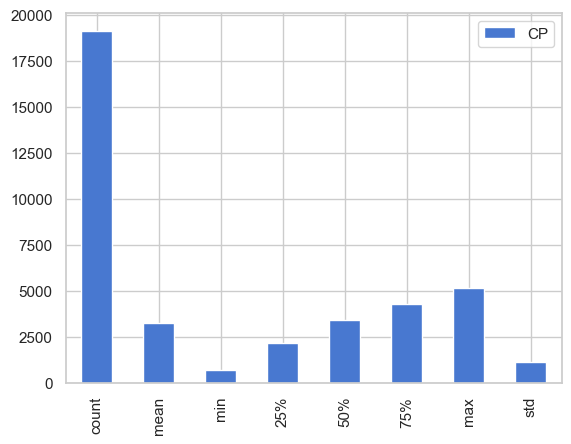

In [6]:
sp500_headlines_2008_2024.describe().plot(kind='bar')

<Axes: xlabel='Date', ylabel='CP'>

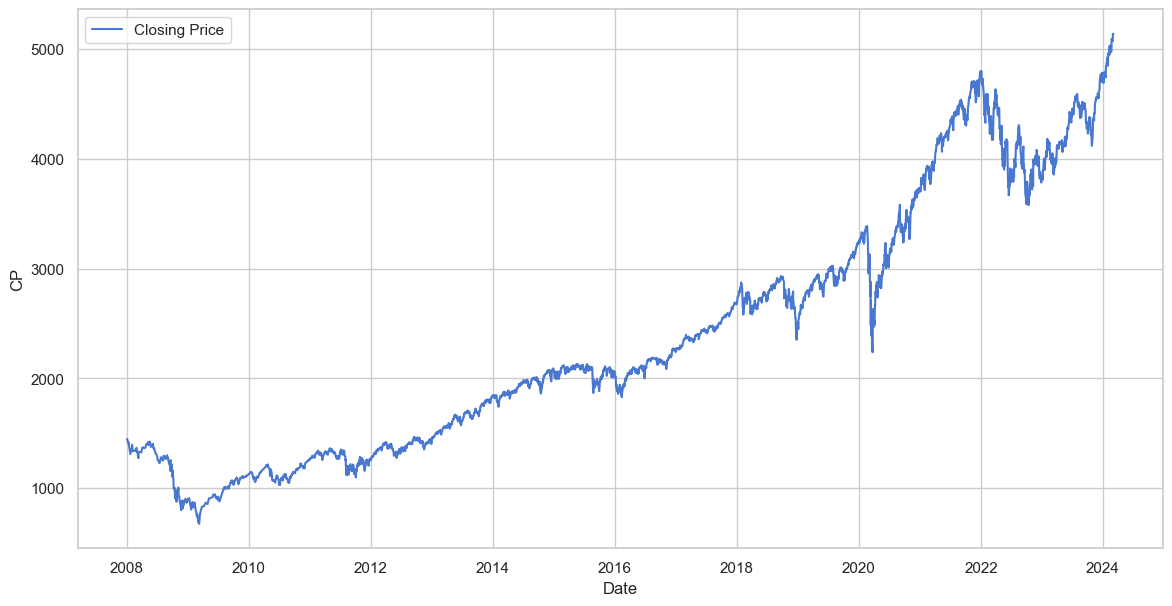

In [7]:
# Plot index prices over time
plt.figure(figsize=(14, 7))
sns.lineplot(x='Date', y='CP', data=sp500_headlines_2008_2024, label='Closing Price')

Numeric columns: Index(['CP'], dtype='object')


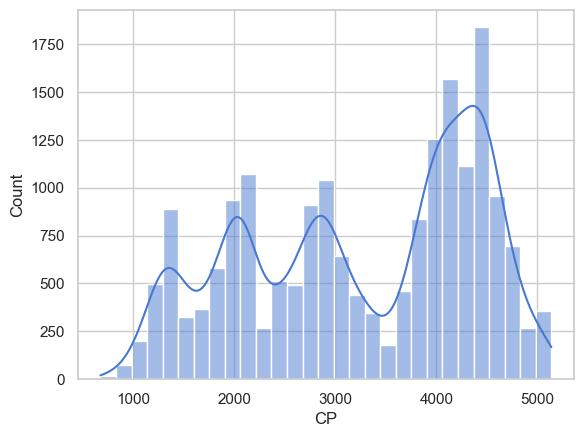

In [8]:
numeric_cols = sp500_headlines_2008_2024.select_dtypes(include=['number']).columns
print("Numeric columns:", numeric_cols)

for col in numeric_cols:
    sns.histplot(x=col, data=sp500_headlines_2008_2024, kde=True)
    plt.show()

## Prepare sentiment data

In [9]:
# Limit the dataset by number of rows for testing
max_rows = len(sp500_headlines_2008_2024)

In [10]:
# Load FinBERT (pre-trained for financial sentiment)
tokenizer = AutoTokenizer.from_pretrained('ProsusAI/finbert')
model = AutoModelForSequenceClassification.from_pretrained('ProsusAI/finbert')

def get_sentiment_score(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

    # Custom score: Positive = +1, Neutral = 0, Negative = -1
    score = (probs[0][2] - probs[0][0]).item()
    return score

# Generate sentiment scores
# For testing purposes, we can limit the number of rows processed
sp500_headlines_2008_2024_test = sp500_headlines_2008_2024.head(max_rows)
tqdm.pandas()
sp500_headlines_2008_2024_test['sentiment_score_finbert'] = sp500_headlines_2008_2024_test['Title'].progress_apply(get_sentiment_score)

print(sp500_headlines_2008_2024_test[['Date', 'Title', 'sentiment_score_finbert']].head())

100%|██████████| 19127/19127 [14:10<00:00, 22.48it/s]

        Date                                              Title  \
0 2008-01-02   JPMorgan Predicts 2008 Will Be "Nothing But Net"   
1 2008-01-02  Dow Tallies Biggest First-session-of-year Poin...   
2 2008-01-02                   2008 predictions for the S&P 500   
3 2008-01-03  U.S. Stocks Higher After Economic Data, Monsan...   
4 2008-01-07  U.S. Stocks Climb As Hopes Increase For More F...   

   sentiment_score_finbert  
0                 0.019026  
1                 0.014999  
2                 0.771308  
3                -0.787446  
4                -0.338189  


In [11]:
tt = sp500_headlines_2008_2024.head(1)

inputs = tokenizer(tt['Title'][0], return_tensors="pt", truncation=True)
outputs = model(**inputs)
probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

print(probs)

# Custom score: Positive = +1, Neutral = 0, Negative = -1
score = (probs[0][2] - probs[0][0]).item()

print(score)

tensor([[0.1884, 0.6042, 0.2074]], grad_fn=<SoftmaxBackward0>)
0.0190257728099823


In [ ]:
# Define volatility period
volatility_period = [5, 22, 66, 132, 252]  # 5 days, 22 days (1 month), 66 days (3 months), 132 days (6 months)

# Daily average sentiment
daily_sentiment = sp500_headlines_2008_2024_test.groupby('Date')['sentiment_score_finbert'].mean().reset_index()
daily_sentiment.rename(columns={'sentiment_score_finbert': 'avg_sentiment_score_a_day'}, inplace=True)

# Calculate rolling n-day sentiment volatility (std deviation)
# a week, a month, a quarter, and half a year
for n in volatility_period:
    daily_sentiment[f'{n}_day_sentiment_volatility'] = daily_sentiment['avg_sentiment_score_a_day'].rolling(window=n).std()

print(daily_sentiment)

           Date  avg_sentiment_score_a_day  5_day_sentiment_volatility  \
0    2008-01-02                   0.268444                         NaN   
1    2008-01-03                  -0.787446                         NaN   
2    2008-01-07                  -0.338189                         NaN   
3    2008-01-09                   0.464082                         NaN   
4    2008-01-10                  -0.367122                    0.510163   
...         ...                        ...                         ...   
3502 2024-02-27                   0.151627                    0.273903   
3503 2024-02-28                   0.247577                    0.273043   
3504 2024-02-29                   0.054997                    0.260560   
3505 2024-03-01                  -0.280157                    0.201183   
3506 2024-03-04                   0.069991                    0.199239   

      22_day_sentiment_volatility  66_day_sentiment_volatility  \
0                             NaN            

In [13]:
# Percentages of each sentiment group by >0, <0, and ==0
def sentiment_percentage(df, column):
    total = len(df)
    positive = len(df[df[column] > 0])
    negative = len(df[df[column] < 0])
    neutral = len(df[df[column] == 0])
    
    return {
        'positive': positive / total * 100,
        'negative': negative / total * 100,
        'neutral': neutral / total * 100
    }

sentiment_stats = sentiment_percentage(daily_sentiment, 'avg_sentiment_score_a_day')
print("Sentiment Statistics:", sentiment_stats)

Sentiment Statistics: {'positive': 90.64727687482178, 'negative': 9.352723125178215, 'neutral': 0.0}


## Prepare market data

In [14]:
# Function to label future crash events based on future close prices
def add_future_crash_label(df, look_ahead_days=252, drop_threshold=0.9, close_col="CP"):
    df = df.copy()
    df["future_close"] = df[close_col].shift(-look_ahead_days)
    df["future_crash"] = (df["future_close"] < df[close_col] * drop_threshold).astype(int)
    return df

# Define look-ahead days and drop threshold
# Number of trading days in a year approximately 252 days
look_ahead_days = 252

# Future close price from today is less than drop_threshold% of the current close price
drop_threshold = 0.9

sp500_headlines_2008_2024_test = add_future_crash_label(sp500_headlines_2008_2024_test, look_ahead_days, drop_threshold)
sp500_headlines_2008_2024_test[['Date', 'CP', 'future_close', 'future_crash']]

,Date,CP,future_close,future_crash
0,2008-01-02,1447.16,1126.42,1
1,2008-01-02,1447.16,1126.42,1
2,2008-01-02,1447.16,1136.52,1
3,2008-01-03,1447.16,1136.52,1
4,2008-01-07,1416.18,1136.52,1
...,...,...,...,...
19122,2024-03-04,5130.95,NaN,0
19123,2024-03-04,5130.95,NaN,0
19124,2024-03-04,5130.95,NaN,0
19125,2024-03-04,5130.95,NaN,0


In [15]:
# Count future crash
crashed = sp500_headlines_2008_2024_test['future_crash'].value_counts()[1]
not_crashed = sp500_headlines_2008_2024_test['future_crash'].value_counts()[0]
print(crashed, not_crashed)

print(f'Ratio of crashed: {round(crashed/(crashed + not_crashed) * 100, 2)} %')

807 18320
Ratio of crashed: 4.22 %


With the sentiment statistic calculated before (negative 9.35%), it's quite reasonable with these ratio of crashes (4.22%) to be related to each other.

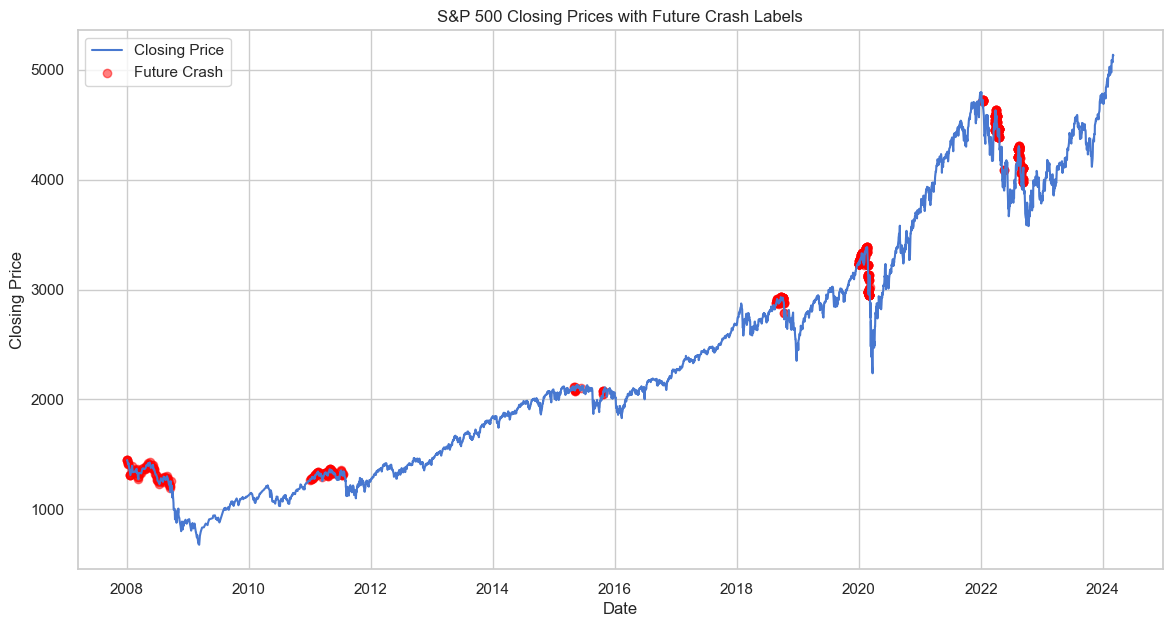

In [16]:
# Plot close prices and future crash labels
plt.figure(figsize=(14, 7))
sns.lineplot(x='Date', y='CP', data=sp500_headlines_2008_2024_test, label='Closing Price')
plt.scatter(sp500_headlines_2008_2024_test[sp500_headlines_2008_2024_test['future_crash'] == 1]['Date'],
            sp500_headlines_2008_2024_test[sp500_headlines_2008_2024_test['future_crash'] == 1]['CP'],
            color='red', label='Future Crash',alpha=0.5)
plt.title('S&P 500 Closing Prices with Future Crash Labels')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [17]:
# Print 'index' of last date with future crash label = 1
print("Last date with future crash label = 1:", sp500_headlines_2008_2024_test[sp500_headlines_2008_2024_test['future_crash'] == 1].index[-1])

# Count data points in each year
print("Data points in each year:")
print(sp500_headlines_2008_2024_test['Date'].dt.year.value_counts().sort_index())

Last date with future crash label = 1: 12732
Data points in each year:
Date
2008     141
2009     113
2010     209
2011     547
2012     724
2013     776
2014     858
2015     818
2016     813
2017     706
2018     840
2019    1848
2020    1519
2021    1303
2022    2319
2023    4760
2024     833
Name: count, dtype: int64


In [69]:
# Count only crashed data points in each year
print("Crashed data points in each year:")
crashed_per_year = sp500_headlines_2008_2024_test[sp500_headlines_2008_2024_test['future_crash'] == 1]['Date'].dt.year.value_counts().sort_index()
print(crashed_per_year)

Crashed data points in each year:
Date
2008     91
2011    100
2015     16
2018     89
2019      7
2020    236
2022    268
Name: count, dtype: int64


In [18]:
# Ratio of data points before and after 2022
before_2022 = len(sp500_headlines_2008_2024_test[sp500_headlines_2008_2024_test['Date'] < '2022-01-01'])
after_2022 = len(sp500_headlines_2008_2024_test[sp500_headlines_2008_2024_test['Date'] >= '2022-01-01'])
print(f"Data points before 2022: {before_2022}, after 2022: {after_2022}") 
print(f"Ratio of data points before 2022: {before_2022 / (before_2022 + after_2022) * 100:.2f}%")

# Ratio of crash data before and after 2022
crashed_before_2022 = len(sp500_headlines_2008_2024_test[(sp500_headlines_2008_2024_test['Date'] < '2022-01-01') & (sp500_headlines_2008_2024_test['future_crash'] == 1)])
crashed_after_2022 = len(sp500_headlines_2008_2024_test[(sp500_headlines_2008_2024_test['Date'] >= '2022-01-01') & (sp500_headlines_2008_2024_test['future_crash'] == 1)])
print(f"Crashes before 2022: {crashed_before_2022}, after 2022: {crashed_after_2022}")
print(f"Ratio of crashes before 2022: {crashed_before_2022 / (crashed_before_2022 + crashed_after_2022) * 100:.2f}%")

Data points before 2022: 11215, after 2022: 7912
Ratio of data points before 2022: 58.63%
Crashes before 2022: 539, after 2022: 268
Ratio of crashes before 2022: 66.79%


In [83]:
# From the info above, it seems to be good if we split the data into 2008-2021, 2022-somewhere in the middle of 2022 for validating, and the rest for testing.
# Explore this hypothesis
train_data = sp500_headlines_2008_2024_test[sp500_headlines_2008_2024_test['Date'] < '2022-01-01']

# Summarize crash date from the rest of the data (exclude training data)
crash_in_rest_data = sp500_headlines_2008_2024_test[(sp500_headlines_2008_2024_test['Date'] >= '2022-01-01') & (sp500_headlines_2008_2024_test['future_crash'] == 1)]
print(crash_in_rest_data['Date'].describe())

count                              268
mean     2022-05-25 22:55:31.343283456
min                2022-01-11 00:00:00
25%                2022-04-01 00:00:00
50%                2022-04-14 00:00:00
75%                2022-08-17 00:00:00
max                2022-09-12 00:00:00
Name: Date, dtype: object


In [ ]:
# From the info above, it seems to be good if we split the data into 2008-2021, 2022-somewhere in the middle of 2022 for validating, and the rest for testing.
train_data = sp500_headlines_2008_2024_test[sp500_headlines_2008_2024_test['Date'] < '2021-01-01']

# Validation data: 2022-01-01 to 2022-05-31
val_data = sp500_headlines_2008_2024_test[(sp500_headlines_2008_2024_test['Date'] >= '2021-01-01') & (sp500_headlines_2008_2024_test['Date'] < '2022-08-01')]

# Test data: 2022-06-01 to the end of the dataset
test_data = sp500_headlines_2008_2024_test[(sp500_headlines_2008_2024_test['Date'] >= '2022-08-01') & (sp500_headlines_2008_2024_test['Date'] < '2023-01-01')]

# Total size of data
total_size = len(train_data) + len(val_data) + len(test_data)

# Print date of each set and show the number of crashes
print("Train data date range:", train_data['Date'].min(), "to", train_data['Date'].max())
print("Validation data date range:", val_data['Date'].min(), "to", val_data['Date'].max())
print("Test data date range:", test_data['Date'].min(), "to", test_data['Date'].max())
print("Number of crashes in train data:", train_data['future_crash'].sum())
print("Number of crashes in validation data:", val_data['future_crash'].sum())
print("Number of crashes in test data:", test_data['future_crash'].sum())
print("Size of train data:", len(train_data), "In percentage:", round(len(train_data) / total_size * 100, 2))
print("Size of validation data:", len(val_data), "In percentage:", round(len(val_data) / total_size * 100, 2))
print("Size of test data:", len(test_data), "In percentage:", round(len(test_data) / total_size * 100, 2))

Train data date range: 2008-01-02 00:00:00 to 2020-12-30 00:00:00
Validation data date range: 2021-01-04 00:00:00 to 2021-12-31 00:00:00
Test data date range: 2022-01-03 00:00:00 to 2024-03-04 00:00:00
Number of crashes in train data: 539
Number of crashes in validation data: 0
Number of crashes in test data: 268
Size of train data: 9912 In percentage: 51.82
Size of validation data: 1303 In percentage: 6.81
Size of test data: 7912 In percentage: 41.37


In [178]:
# Calculate daily returns
sp500_headlines_2008_2024_test['daily_return'] = sp500_headlines_2008_2024_test['CP'].pct_change() * 100  # Convert to percentage

# Prepare market data
market_data = sp500_headlines_2008_2024_test[['Date', 'CP', 'future_close', 'future_crash', 'daily_return']].copy()
market_data['Date'] = pd.to_datetime(market_data['Date'])

market_data

,Date,CP,future_close,future_crash,daily_return
0,2008-01-02,1447.16,1126.42,1,NaN
1,2008-01-02,1447.16,1126.42,1,0.000000
2,2008-01-02,1447.16,1136.52,1,0.000000
3,2008-01-03,1447.16,1136.52,1,0.000000
4,2008-01-07,1416.18,1136.52,1,-2.140745
...,...,...,...,...,...
19122,2024-03-04,5130.95,NaN,0,0.000000
19123,2024-03-04,5130.95,NaN,0,0.000000
19124,2024-03-04,5130.95,NaN,0,0.000000
19125,2024-03-04,5130.95,NaN,0,0.000000


In [179]:
# Calculate n-day returns
def calculate_n_day_returns(data, volatility_period):
    for n in volatility_period:
        data[f'{n}_day_market_return'] = data['CP'].pct_change(periods=n) * 100  # Convert to percentage
    return data

market_data = calculate_n_day_returns(market_data, volatility_period)
market_data

,Date,CP,future_close,future_crash,daily_return,5_day_market_return,22_day_market_return,66_day_market_return,132_day_market_return
0,2008-01-02,1447.16,1126.42,1,NaN,NaN,NaN,NaN,NaN
1,2008-01-02,1447.16,1126.42,1,0.000000,NaN,NaN,NaN,NaN
2,2008-01-02,1447.16,1136.52,1,0.000000,NaN,NaN,NaN,NaN
3,2008-01-03,1447.16,1136.52,1,0.000000,NaN,NaN,NaN,NaN
4,2008-01-07,1416.18,1136.52,1,-2.140745,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
19122,2024-03-04,5130.95,NaN,0,0.000000,0.0,0.0,0.680498,1.211552
19123,2024-03-04,5130.95,NaN,0,0.000000,0.0,0.0,0.680498,1.211552
19124,2024-03-04,5130.95,NaN,0,0.000000,0.0,0.0,0.680498,1.211552
19125,2024-03-04,5130.95,NaN,0,0.000000,0.0,0.0,0.680498,1.211552


In [180]:
# Calculate n-day volatility
def calculate_n_day_volatility(data, volatility_period):
    for n in volatility_period:
        data[f'{n}_day_market_volatility'] = data['daily_return'].rolling(window=n).std() * np.sqrt(n)  # Standard deviation of closing prices
    return data

market_data = calculate_n_day_volatility(market_data, volatility_period)
market_data

,Date,CP,future_close,future_crash,daily_return,5_day_market_return,22_day_market_return,66_day_market_return,132_day_market_return,5_day_market_volatility,22_day_market_volatility,66_day_market_volatility,132_day_market_volatility
0,2008-01-02,1447.16,1126.42,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2008-01-02,1447.16,1126.42,1,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2008-01-02,1447.16,1136.52,1,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2008-01-03,1447.16,1136.52,1,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2008-01-07,1416.18,1136.52,1,-2.140745,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19122,2024-03-04,5130.95,NaN,0,0.000000,0.0,0.0,0.680498,1.211552,0.0,0.0,0.811438,0.990902
19123,2024-03-04,5130.95,NaN,0,0.000000,0.0,0.0,0.680498,1.211552,0.0,0.0,0.811438,0.990902
19124,2024-03-04,5130.95,NaN,0,0.000000,0.0,0.0,0.680498,1.211552,0.0,0.0,0.811438,0.990902
19125,2024-03-04,5130.95,NaN,0,0.000000,0.0,0.0,0.680498,1.211552,0.0,0.0,0.811438,0.990902


## Align market data with sentiment data

In [181]:
# Merge market data with daily sentiment
print(daily_sentiment.shape)
print(market_data.shape)
market_sentiment_data = market_data.merge(daily_sentiment, on='Date', how='left')
market_sentiment_data

(3507, 6)
(19127, 13)


,Date,CP,future_close,future_crash,daily_return,5_day_market_return,22_day_market_return,66_day_market_return,132_day_market_return,5_day_market_volatility,22_day_market_volatility,66_day_market_volatility,132_day_market_volatility,avg_sentiment_score_a_day,5_day_sentiment_volatility,22_day_sentiment_volatility,66_day_sentiment_volatility,132_day_sentiment_volatility
0,2008-01-02,1447.16,1126.42,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.268444,NaN,NaN,NaN,NaN
1,2008-01-02,1447.16,1126.42,1,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.268444,NaN,NaN,NaN,NaN
2,2008-01-02,1447.16,1136.52,1,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.268444,NaN,NaN,NaN,NaN
3,2008-01-03,1447.16,1136.52,1,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.787446,NaN,NaN,NaN,NaN
4,2008-01-07,1416.18,1136.52,1,-2.140745,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.338189,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19122,2024-03-04,5130.95,NaN,0,0.000000,0.0,0.0,0.680498,1.211552,0.0,0.0,0.811438,0.990902,0.069991,0.199239,0.201547,0.194642,0.178143
19123,2024-03-04,5130.95,NaN,0,0.000000,0.0,0.0,0.680498,1.211552,0.0,0.0,0.811438,0.990902,0.069991,0.199239,0.201547,0.194642,0.178143
19124,2024-03-04,5130.95,NaN,0,0.000000,0.0,0.0,0.680498,1.211552,0.0,0.0,0.811438,0.990902,0.069991,0.199239,0.201547,0.194642,0.178143
19125,2024-03-04,5130.95,NaN,0,0.000000,0.0,0.0,0.680498,1.211552,0.0,0.0,0.811438,0.990902,0.069991,0.199239,0.201547,0.194642,0.178143


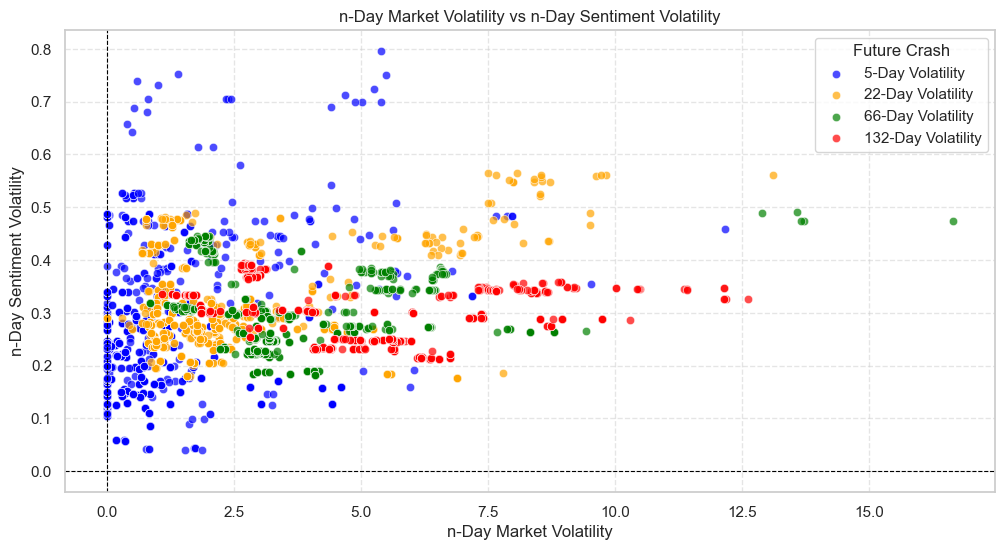

In [182]:
# Plot relationship between future crash and n-day market volatility combined with sentiment volatility
# Plot for 5 day, 22 day, 66 day, and 126 day volatility
crash_data = market_sentiment_data[market_sentiment_data['future_crash'] == 1]

# Scale the market volatility and sentiment volatility for better visualization
def scale_to_0_1(series):
    return (series - series.min()) / (series.max() - series.min())

plt.figure(figsize=(12, 6))
sns.scatterplot(x='5_day_market_volatility', y='5_day_sentiment_volatility', data=crash_data, label='5-Day Volatility', alpha=0.7, color='blue')
sns.scatterplot(x='22_day_market_volatility', y='22_day_sentiment_volatility', data=crash_data, label='22-Day Volatility', alpha=0.7, color='orange')
sns.scatterplot(x='66_day_market_volatility', y='66_day_sentiment_volatility', data=crash_data, label='66-Day Volatility', alpha=0.7, color='green')
sns.scatterplot(x='132_day_market_volatility', y='132_day_sentiment_volatility', data=crash_data, label='132-Day Volatility', alpha=0.7, color='red')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.axvline(0, color='black', linestyle='--', linewidth=0.8)
plt.grid(True, linestyle='--', alpha=0.5)
plt.title('n-Day Market Volatility vs n-Day Sentiment Volatility')
plt.xlabel('n-Day Market Volatility')
plt.ylabel('n-Day Sentiment Volatility')
plt.legend(title='Future Crash', loc='upper right')
plt.show()

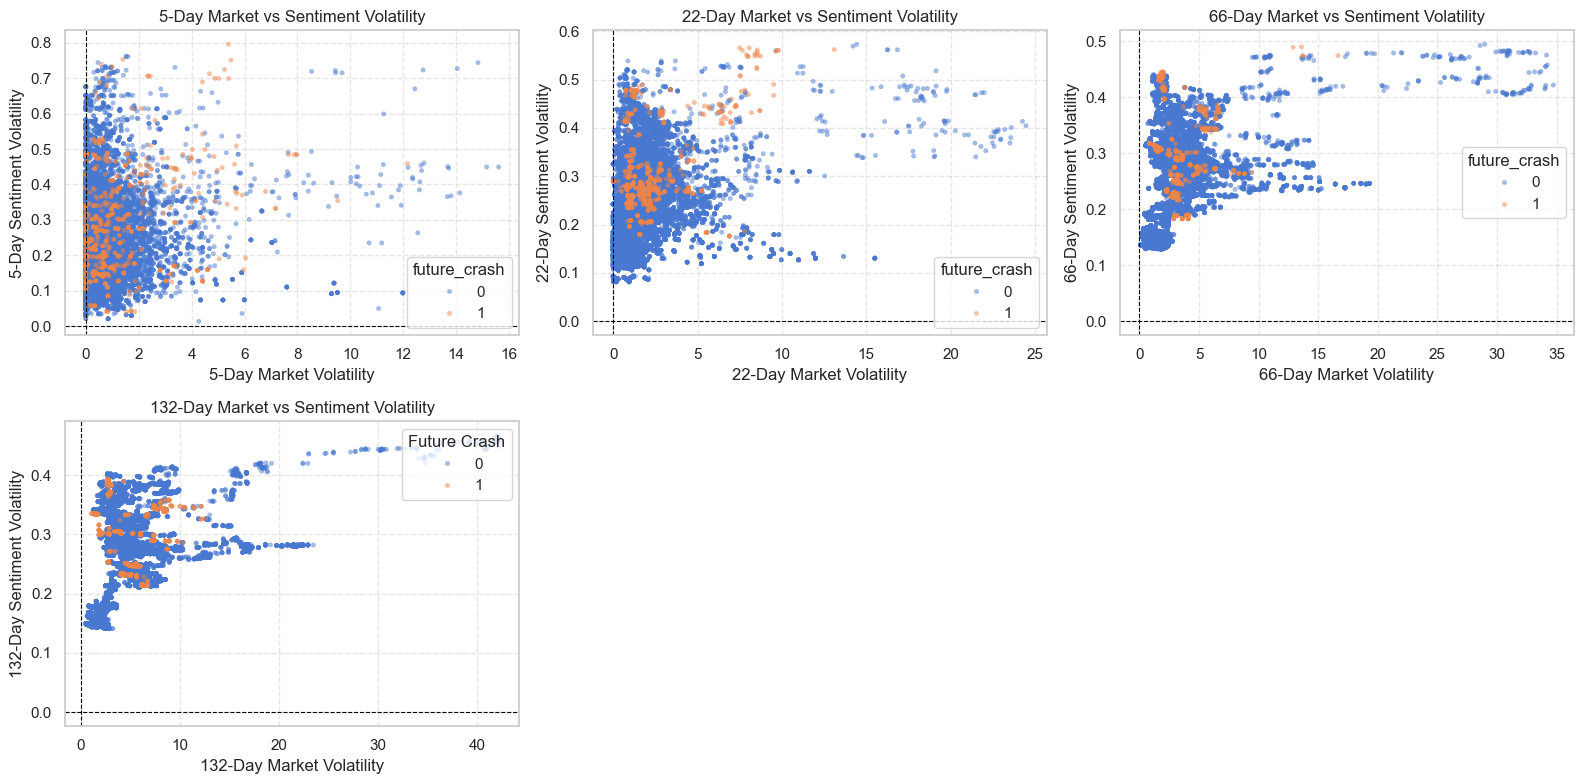

In [183]:
n_cols = 3
n_rows = (len(volatility_period) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten()

df_sorted = market_sentiment_data.sort_values('future_crash')

for idx, n in enumerate(volatility_period):
    ax = axes[idx]
    x_col = f'{n}_day_market_volatility'
    y_col = f'{n}_day_sentiment_volatility'

    # Drop NA values for clean plot
    df_plot = df_sorted.dropna(subset=[x_col, y_col, 'future_crash'])

    sns.scatterplot(
        x=x_col, y=y_col, hue='future_crash', data=df_plot, alpha=0.5, ax=ax, edgecolor=None, s=10
    )
    ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
    ax.axvline(0, color='black', linestyle='--', linewidth=0.8)
    ax.set_title(f'{n}-Day Market vs Sentiment Volatility')
    ax.set_xlabel(f'{n}-Day Market Volatility')
    ax.set_ylabel(f'{n}-Day Sentiment Volatility')
    ax.grid(True, linestyle='--', alpha=0.5)

# Remove unused subplots
for j in range(len(volatility_period), len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.legend(title='Future Crash', loc='upper right')
plt.show()

## Modelling

### Add VaR and ES features

In [184]:
def add_var_es_features(df, return_col='daily_return', windows=volatility_period, confidence=0.05):
    df = df.copy()
    z_score = abs(np.percentile(np.random.normal(size=100000), confidence * 100))  # ≈1.64 for 95%, 1.96 for 97.5%

    for w in windows:
        # Rolling mean and std of returns
        rolling_mu = df[return_col].rolling(window=w).mean()
        rolling_sigma = df[return_col].rolling(window=w).std()

        # Parametric Gaussian VaR (1-day, % return)
        df[f'VaR_{w}'] = - (rolling_mu + z_score * rolling_sigma)

        # Expected Shortfall (ES) assuming normal distribution
        pdf_factor = np.exp(-0.5 * z_score**2) / (np.sqrt(2 * np.pi))
        cdf_factor = confidence
        df[f'ES_{w}'] = - (rolling_mu + (rolling_sigma * pdf_factor / cdf_factor))
    
    return df

market_sentiment_data = add_var_es_features(market_sentiment_data, return_col='daily_return')

In [185]:
market_sentiment_data.columns

Index(['Date', 'CP', 'future_close', 'future_crash', 'daily_return',
       '5_day_market_return', '22_day_market_return', '66_day_market_return',
       '132_day_market_return', '5_day_market_volatility',
       '22_day_market_volatility', '66_day_market_volatility',
       '132_day_market_volatility', 'avg_sentiment_score_a_day',
       '5_day_sentiment_volatility', '22_day_sentiment_volatility',
       '66_day_sentiment_volatility', '132_day_sentiment_volatility', 'VaR_5',
       'ES_5', 'VaR_22', 'ES_22', 'VaR_66', 'ES_66', 'VaR_132', 'ES_132'],
      dtype='object')

In [280]:
train_data = market_sentiment_data[market_sentiment_data['Date'] < '2022-01-01']
test_data = market_sentiment_data[market_sentiment_data['Date'] >= '2022-01-01']
target_col = 'future_crash'

print(train_data.shape, test_data.shape)

(11215, 26) (7912, 26)


### RandomForest (Random Split)

In [282]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=RANDOM_STATE),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=1
)

rf_results = {}
X_test_dict = {}
y_test_dict = {}

for n in volatility_period:
    feature_cols = [
        f'{n}_day_market_volatility',
        f'{n}_day_sentiment_volatility',
        f'VaR_{n}',
        f'ES_{n}',
    ]

    # Drop rows with NaN values in feature columns
    X = market_sentiment_data[feature_cols].dropna()
    y = market_sentiment_data.loc[X.index, target_col]

    X = X.fillna(X.mean())  # Fill NaN values with column means
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=RANDOM_STATE) 
    X_resampled, y_resampled = sm.fit_resample(X_train, y_train)
    
    X_test_dict[n] = X_test
    y_test_dict[n] = y_test

    grid.fit(X_resampled, y_resampled)

    print("Best params:", grid.best_params_)
    print("Best AUC on CV:", grid.best_score_)

    # Reuse best model
    rf_model = grid.best_estimator_

    # Predict
    y_pred = rf_model.predict(X_test)
    y_proba = rf_model.predict_proba(X_test)[:, 1]

    print(classification_report(y_test, y_pred))
    print("Best Model ROC AUC:", roc_auc_score(y_test, y_proba))

    # Save everything for later
    rf_results[n] = {
        'model': rf_model,
        'best_params': grid.best_params_,
        'classification_report': classification_report(y_test, y_pred, output_dict=True)
    }


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best params: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best AUC on CV: 0.9866757159913243
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3664
           1       0.56      0.74      0.64       160

    accuracy                           0.96      3824
   macro avg       0.77      0.86      0.81      3824
weighted avg       0.97      0.96      0.97      3824

Best Model ROC AUC: 0.9370744063864629
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best params: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best AUC on CV: 0.9985133927176785
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3664
           1       0.78      0.90      0.83       155

    accuracy                           0.99      3819
   macro avg       0.89   

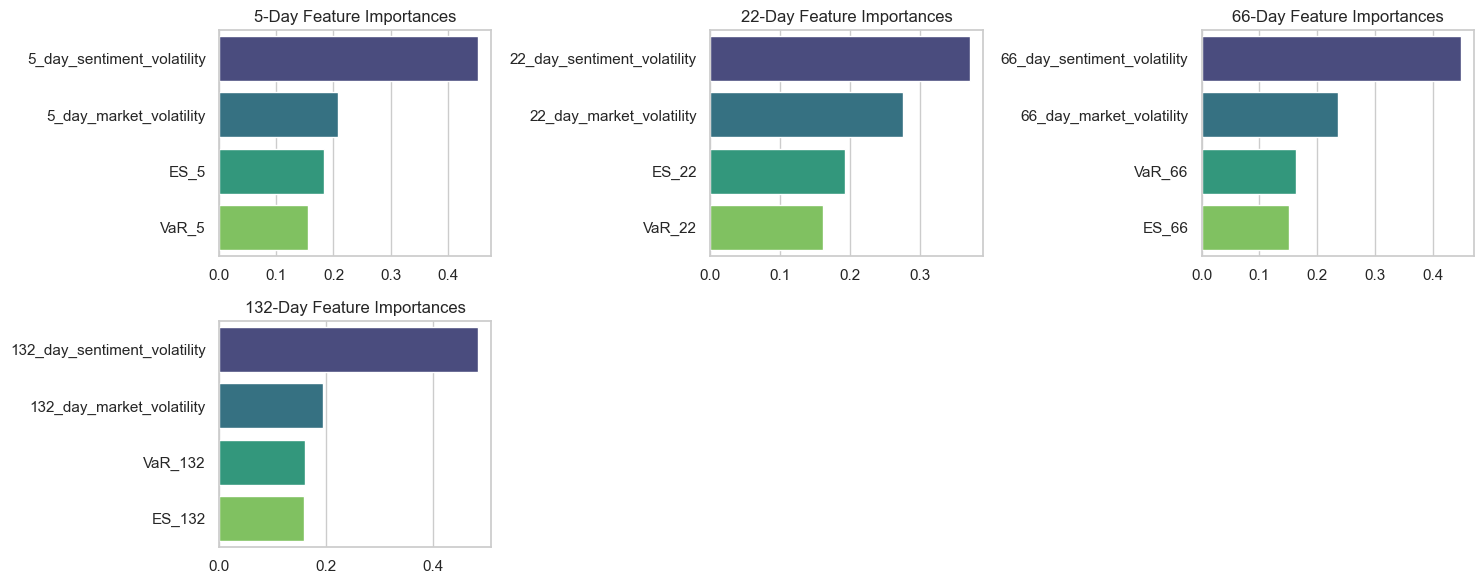

In [283]:
plot_feature_importances_grid(rf_results)

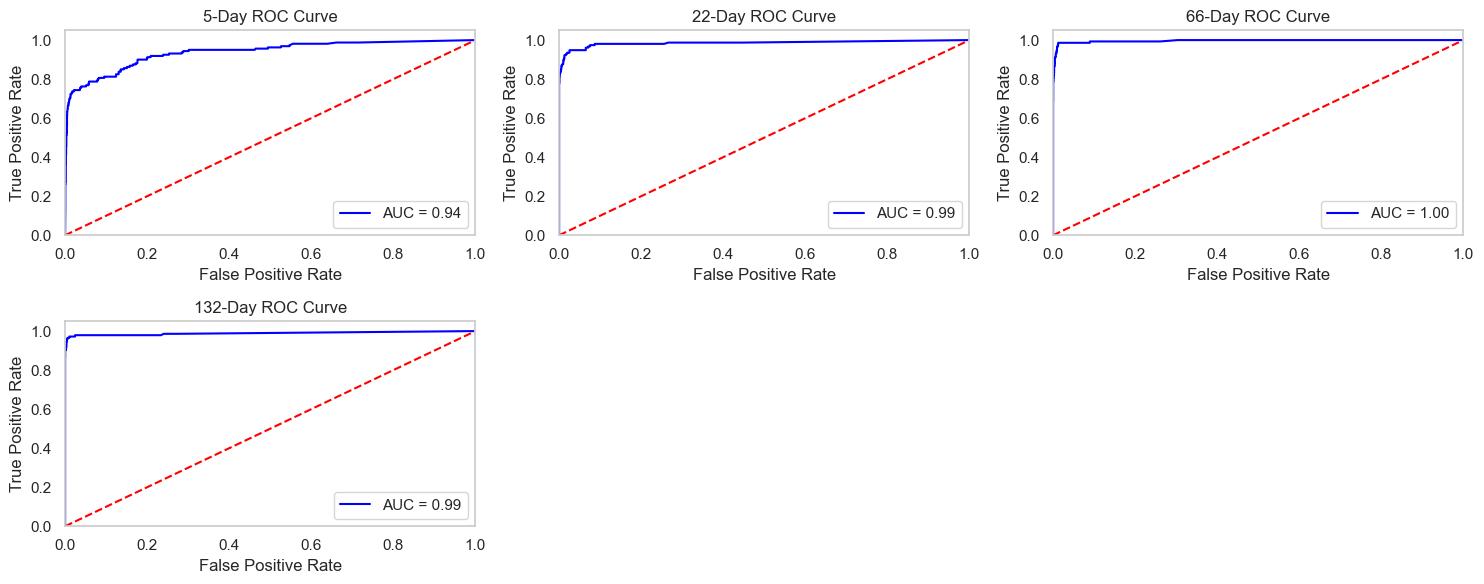

In [284]:
plot_roc_curves_grid(rf_results, X_test_dict, y_test_dict)

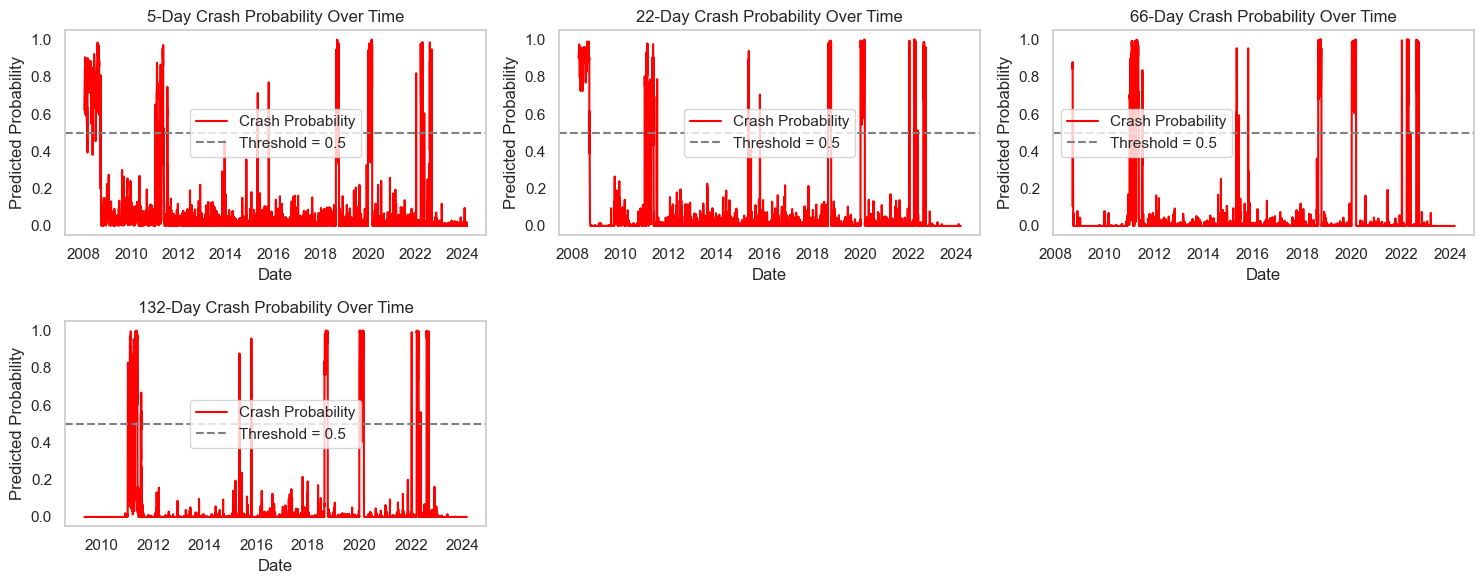

In [285]:
plot_crash_probabilities_grid(rf_results, market_sentiment_data, target_col='future_crash')

### Logit Model

In [320]:
from sklearn.linear_model import LogisticRegression

logit_results = {}
X_test_dict = {}
y_test_dict = {}

for n in volatility_period:
    feature_cols = [
        f'{n}_day_market_volatility',
        f'{n}_day_sentiment_volatility',
        f'VaR_{n}',
        f'ES_{n}',
    ]

    # Drop NA rows for this n
    df_model = market_sentiment_data.dropna(subset=feature_cols + ['future_crash']).copy()
    
    X = df_model[feature_cols]
    y = df_model['future_crash']

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=RANDOM_STATE) 
    X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

    scaler = StandardScaler()
    X_resampled = scaler.fit_transform(X_resampled)
    X_test = scaler.transform(X_test)

    logit = LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced')  # L1/L2 penalty support
    logit.fit(X_resampled, y_resampled)

    # y_proba = logit.predict_proba(X_test)[:, 1]
    # best_thresh = dynamic_threshold_calculate(y_test, y_proba)
    # y_pred = (y_proba >= best_thresh).astype(int)

    y_pred = logit.predict(X_test)
    y_proba = logit.predict_proba(X_test)[:, 1]

    # Save results
    auc_score = roc_auc_score(y_test, y_proba)
    report = classification_report(y_test, y_pred)

    coefficients = pd.DataFrame({
        'Feature': feature_cols,
        'Coefficient': logit.coef_[0]
    }).sort_values(by='Coefficient', key=abs, ascending=False)

    logit_results[n] = {
        'model': logit,
        'auc': auc_score,
        'report': report,
        'coefficients': coefficients,
    }

    # Store for ROC plotting, etc.
    X_test_dict[n] = X_test
    y_test_dict[n] = y_test

    # Optional print
    print(f"\n=== {n}-Day Logit Model ===")
    print(f"AUC: {auc_score:.3f}")
    print("classification_report:")
    print(report)


=== 5-Day Logit Model ===
AUC: 0.649
classification_report:
              precision    recall  f1-score   support

           0       0.97      0.67      0.79      5496
           1       0.06      0.50      0.11       240

    accuracy                           0.66      5736
   macro avg       0.52      0.59      0.45      5736
weighted avg       0.93      0.66      0.76      5736


=== 22-Day Logit Model ===
AUC: 0.693
classification_report:
              precision    recall  f1-score   support

           0       0.97      0.62      0.76      5496
           1       0.06      0.59      0.11       233

    accuracy                           0.62      5729
   macro avg       0.52      0.60      0.44      5729
weighted avg       0.94      0.62      0.73      5729


=== 66-Day Logit Model ===
AUC: 0.666
classification_report:
              precision    recall  f1-score   support

           0       0.97      0.55      0.71      5497
           1       0.05      0.60      0.09       21

Logistic regression coefficients represent the log odds change in the dependent variable (e.g., financial crash) for a one-unit change in the predictor variable. So:
1. Large positive coefficients → strong positive influence on crash probability.
2. Large negative coefficients → strong negative influence (protective effect).
3. Coefficients near 0 → less influential.

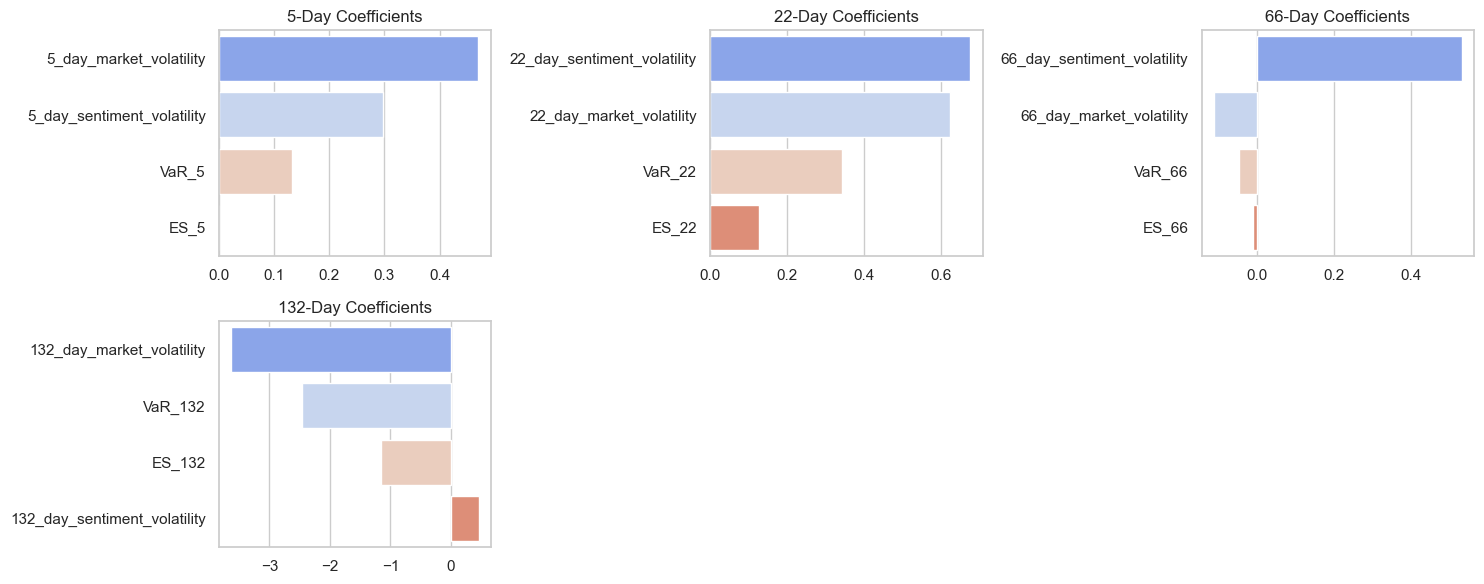

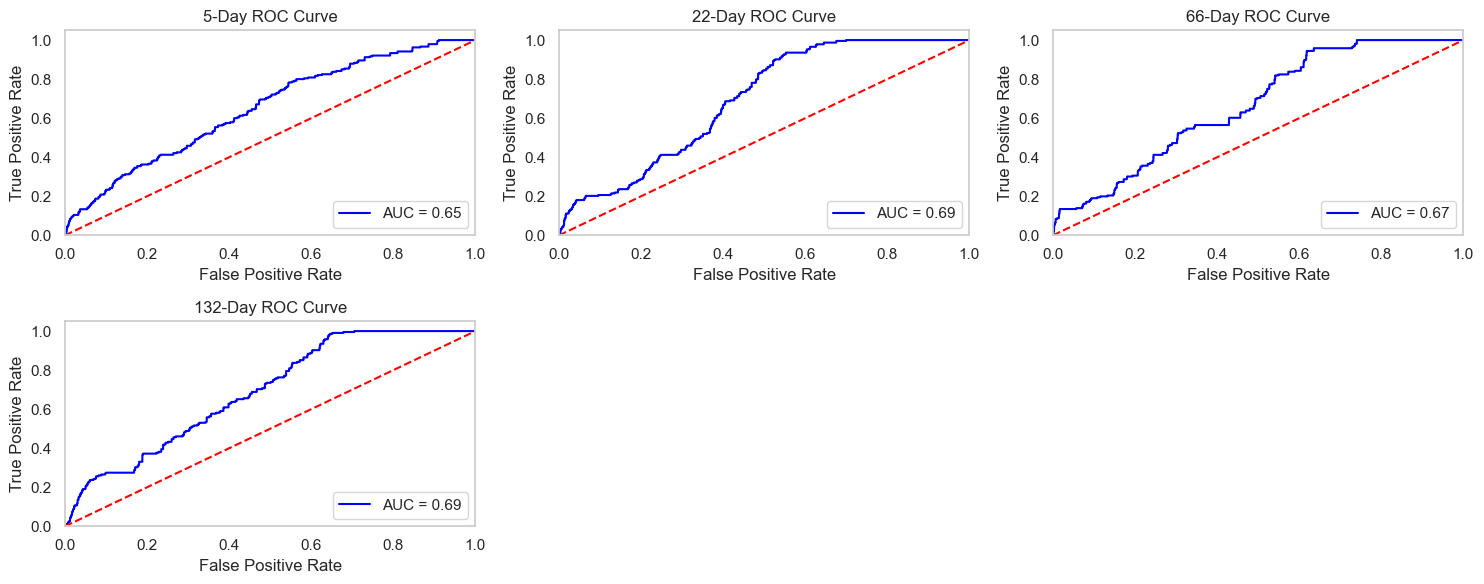

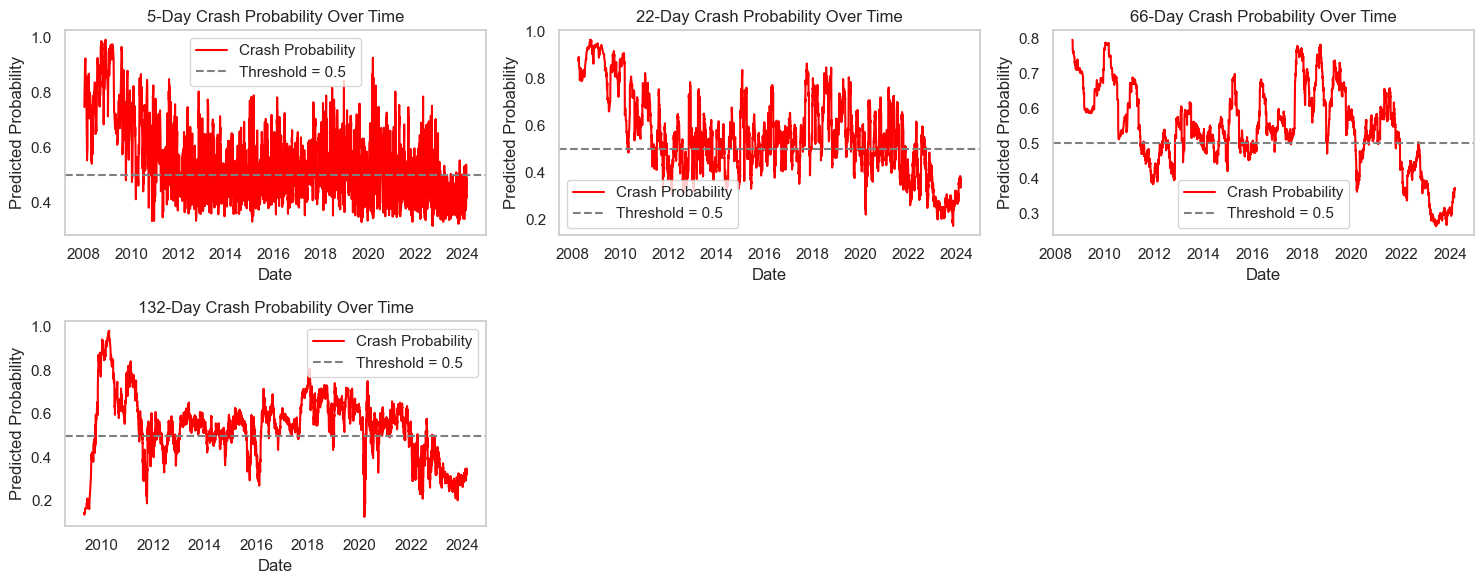

In [287]:
plot_logit_coefficients_grid(logit_results)
plot_roc_curves_grid(logit_results, X_test_dict, y_test_dict)
plot_crash_probabilities_grid(logit_results, market_sentiment_data, target_col='future_crash')

### Logit Regression (Date Split)

In [ ]:
logit_results = {}
X_test_dict = {}
y_test_dict = {}

for n in volatility_period:
    feature_cols = [
        f'{n}_day_market_volatility',
        f'{n}_day_sentiment_volatility',
        f'VaR_{n}',
        f'ES_{n}',
    ]

    train_data = market_sentiment_data[market_sentiment_data['Date'] < '2022-01-01']
    test_data = market_sentiment_data[(market_sentiment_data['Date'] >= '2022-01-01')]
    train_df = train_data.dropna(subset=feature_cols+['future_crash']).copy()
    test_df = test_data.dropna(subset=feature_cols+['future_crash']).copy()

    # Prepare feature matrices and target vectors
    X_train = train_df[feature_cols].fillna(train_df[feature_cols].mean())
    y_train = train_df['future_crash']

    X_test = test_df[feature_cols].fillna(train_df[feature_cols].mean())
    y_test = test_df['future_crash']
    
    # Apply SMOTE or any resampling to the training set only
    X_resampled, y_resampled = sm.fit_resample(X_train, y_train)
    # X_resampled, y_resampled = X_train, y_train  # For simplicity, using original training data without resampling

    scaler = StandardScaler()
    X_resampled = scaler.fit_transform(X_resampled)
    X_test = scaler.transform(X_test)

    # Fit Logistic Regression
    logit = LogisticRegression(
        penalty='l2',
        max_iter=1000, 
        solver='liblinear', 
        class_weight='balanced')
    logit.fit(X_resampled, y_resampled)

    # Predict on training set
    y_pred_train = logit.predict(X_resampled)
    y_proba_train = logit.predict_proba(X_resampled)[:, 1]

    # Predict on test set
    # y_pred_test = logit.predict(X_test)
    # y_proba_test = logit.predict_proba(X_test)[:, 1]

    y_proba_test = logit.predict_proba(X_test)[:, 1]
    best_thresh = dynamic_threshold_calculate(y_test, y_proba_test)
    y_pred_test = (y_proba_test >= best_thresh).astype(int)

    # Log loss (cross-entropy)
    train_loss = log_loss(y_resampled, y_proba_train)

    # Save results
    auc_test = roc_auc_score(y_test, y_proba_test)
    report_test = classification_report(y_test, y_pred_test, output_dict=True)

    coefficients = pd.DataFrame({
        'Feature': feature_cols,
        'Coefficient': logit.coef_[0]
    }).sort_values(by='Coefficient', key=abs, ascending=False)

    logit_results[n] = {
        'model': logit,
        'auc_test': auc_test,
        'train_log_loss': train_loss,
        'report_test': report_test,
        'coefficients': coefficients,
        'y_test_pred': y_pred_test,
        'y_test_proba': y_proba_test,
    }

    # Save test set for plotting or later comparison
    X_test_dict[n] = X_test
    y_test_dict[n] = y_test

    # Print summary
    print(f"\n=== {n}-Day Logit Model ===")
    print(f"Test AUC: {auc_test:.3f}")
    print("Classification Report (Test):")
    print(classification_report(y_test, y_pred_test))

(11215, 26) (7912, 26)
Best threshold: 0.49, F1: 0.13

=== 5-Day Logit Model ===
Test AUC: 0.576
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.97      0.87      0.92      7644
           1       0.08      0.34      0.13       268

    accuracy                           0.85      7912
   macro avg       0.53      0.60      0.53      7912
weighted avg       0.94      0.85      0.89      7912

Best threshold: 0.43, F1: 0.41

=== 22-Day Logit Model ===
Test AUC: 0.917
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      7644
           1       0.31      0.58      0.41       268

    accuracy                           0.94      7912
   macro avg       0.65      0.77      0.69      7912
weighted avg       0.96      0.94      0.95      7912

Best threshold: 0.31, F1: 0.25

=== 66-Day Logit Model ===
Test AUC: 0.787
Classification Report (Test):
         

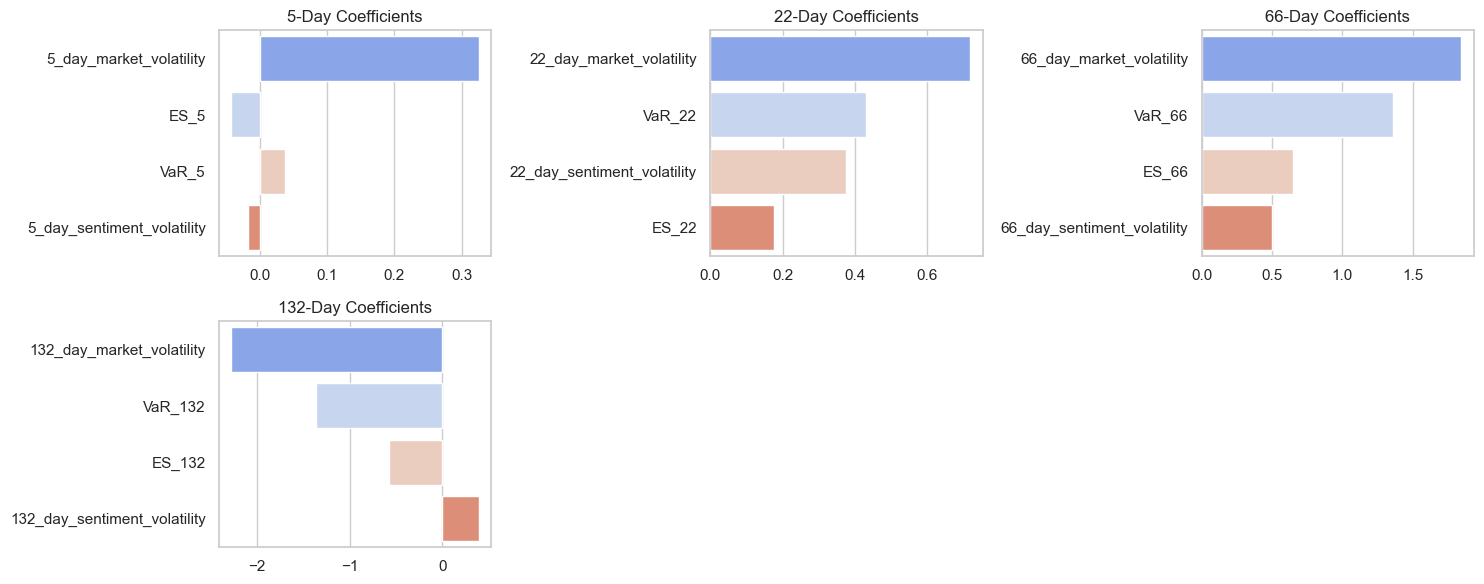

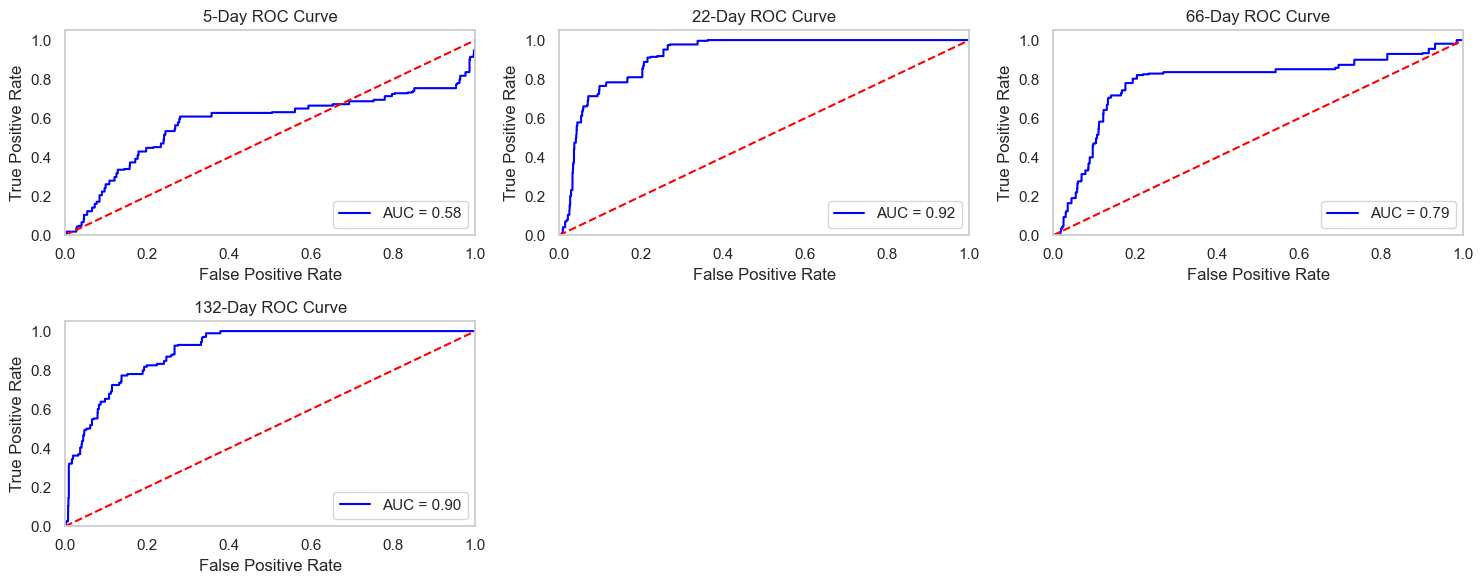

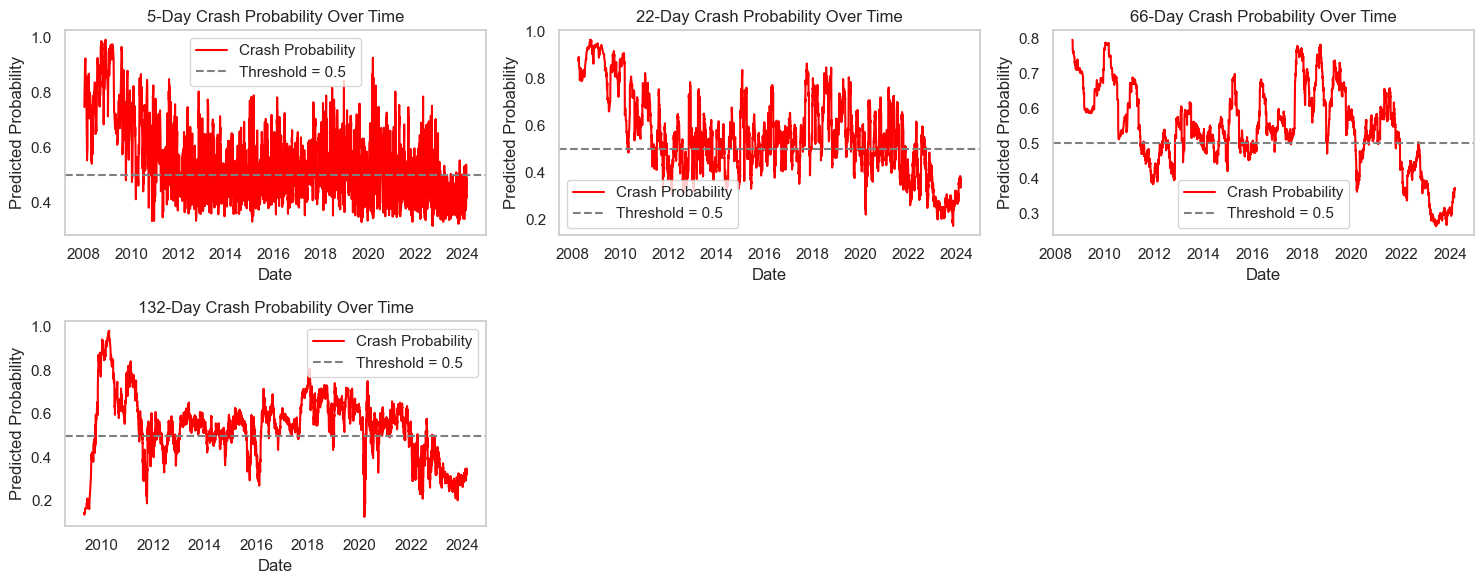

In [323]:
plot_logit_coefficients_grid(logit_results)
plot_roc_curves_grid(logit_results, X_test_dict, y_test_dict)
plot_crash_probabilities_grid(logit_results, market_sentiment_data, target_col='future_crash')

### Logit Regression with combined sentiment features

In [363]:
# Define combined feature period
combined_period = 0

# Combine 5-day and 22-day features
combined_features = [
    '66_day_market_volatility',
    '66_day_sentiment_volatility',
    'VaR_66',
    'ES_66',
]

df_combined = market_sentiment_data.dropna(subset=combined_features + ['future_crash']).copy()
# X = df_combined[combined_features]
# y = df_combined['future_crash']

# # Split and apply SMOTE
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=RANDOM_STATE)
train_data = market_sentiment_data[market_sentiment_data['Date'] < '2022-01-01']
test_data = market_sentiment_data[(market_sentiment_data['Date'] >= '2022-01-01')]
train_df = train_data.dropna(subset=combined_features+['future_crash']).copy()
test_df = test_data.dropna(subset=combined_features+['future_crash']).copy()

# Prepare feature matrices and target vectors
X_train = train_df[combined_features].fillna(train_df[combined_features].mean())
y_train = train_df['future_crash']

X_test = test_df[combined_features].fillna(train_df[combined_features].mean())
y_test = test_df['future_crash']

X_resampled, y_resampled = X_train.copy(), y_train.copy()

scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)
X_test_scale = scaler.transform(X_test)

# Fit logistic regression
logit = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    max_iter=1000, 
    class_weight='balanced',
    C=1.0,
    l1_ratio=0.5)
logit.fit(X_resampled, y_resampled)

y_proba = logit.predict_proba(X_test_scale)[:, 1]
best_thresh = dynamic_threshold_calculate(y_test, y_proba)
y_pred = (y_proba >= best_thresh).astype(int)

# Evaluation
auc_score = roc_auc_score(y_test, y_proba)
report = classification_report(y_test, y_pred)

coefficients = pd.DataFrame({
    'Feature': combined_features,
    'Coefficient': logit.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Store results
logit_results[combined_period] = {
    'model': logit,
    'auc_score': auc_score,
    'report': report,
    'coefficients': coefficients,
}

X_test_dict[combined_period] = X_test
y_test_dict[combined_period] = y_test

# Print summary
print(f"\n=== Combined Logit Model ===")
print(f"AUC: {auc_score:.3f}")
print("Classification Report:")
print(report)

Best threshold: 0.31, F1: 0.26

=== Combined Logit Model ===
AUC: 0.791
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.87      0.92      7644
           1       0.16      0.70      0.26       268

    accuracy                           0.86      7912
   macro avg       0.57      0.78      0.59      7912
weighted avg       0.96      0.86      0.90      7912



Precision and Recall for Combined Model:
              precision    recall  f1-score   support

           0       0.99      0.87      0.92      7644
           1       0.16      0.70      0.26       268

    accuracy                           0.86      7912
   macro avg       0.57      0.78      0.59      7912
weighted avg       0.96      0.86      0.90      7912



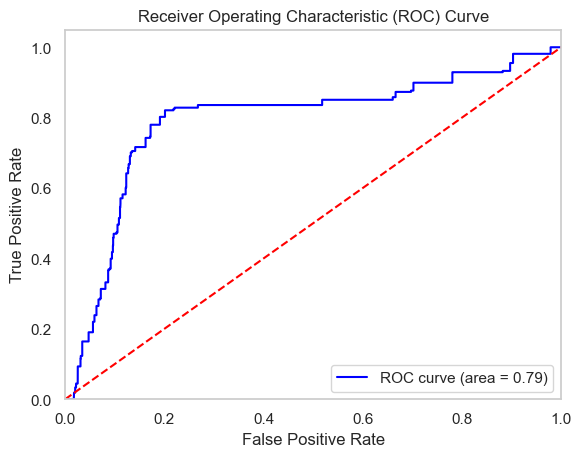

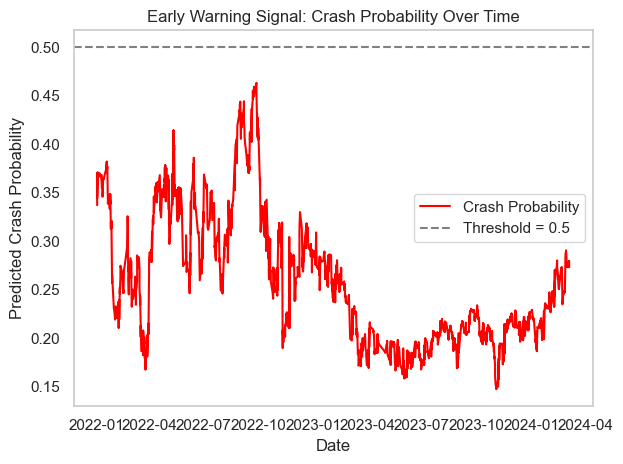

In [364]:
# Create DataFrame with dates and probabilities
dates = df_combined.loc[X_test.index, 'Date']
prob_df = pd.DataFrame({
    'Date': dates,
    'crash_probability': y_proba
}).sort_values('Date')

# Report precision and recall
print("Precision and Recall for Combined Model:")
print(classification_report(y_test, y_pred))

# Plot ROC curve
plot_roc_curve(y_test, y_proba)

# Plot crash probabilities
plot_crash_probabilities(prob_df, target_col='crash_probability')

### Dynamic Logit Regression

In [387]:
logit_results = {}
X_test_dict = {}
y_test_dict = {}

lag = 10  # dynamic variable
market_sentiment_data_with_lags = market_sentiment_data.copy()

for n in volatility_period:
    # Base features
    base_features = [
        f'{n}_day_market_volatility',
        f'{n}_day_sentiment_volatility',
        f'VaR_{n}',
        f'ES_{n}',
    ]

    # Add lagged features
    for feat in base_features:
        market_sentiment_data_with_lags[f'{feat}_lag{lag}'] = market_sentiment_data[feat].shift(lag)

    feature_cols = base_features + [f'{f}_lag{lag}' for f in base_features]

    train_data = market_sentiment_data_with_lags[market_sentiment_data_with_lags['Date'] < '2022-01-01']
    test_data = market_sentiment_data_with_lags[(market_sentiment_data_with_lags['Date'] >= '2022-01-01')]
    train_df = train_data.dropna(subset=feature_cols+['future_crash']).copy()
    test_df = test_data.dropna(subset=feature_cols+['future_crash']).copy()

    # Prepare feature matrices and target vectors
    X_train = train_df[feature_cols].fillna(train_df[feature_cols].mean())
    y_train = train_df['future_crash']

    X_test = test_df[feature_cols].fillna(train_df[feature_cols].mean())
    y_test = test_df['future_crash']
    
    # Oversample
    X_resampled, y_resampled = sm.fit_resample(X_train, y_train)
    # X_resampled, y_resampled = X_train.copy(), y_train.copy()

    scaler = StandardScaler()
    X_resampled = scaler.fit_transform(X_resampled)
    X_test = scaler.transform(X_test)

    # Fit logistic regression
    logit = LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced')
    logit.fit(X_resampled, y_resampled)

    # Predict
    y_proba = logit.predict_proba(X_test)[:, 1]
    best_thresh = dynamic_threshold_calculate(y_test, y_proba)
    y_pred = (y_proba >= best_thresh).astype(int)
    # y_pred = logit.predict(X_test)
    
    # Save results
    auc_score = roc_auc_score(y_test, y_proba)
    report = classification_report(y_test, y_pred)

    coefficients = pd.DataFrame({
        'Feature': feature_cols,
        'Coefficient': logit.coef_[0]
    }).sort_values(by='Coefficient', key=abs, ascending=False)

    logit_results[n] = {
        'model': logit,
        'auc': auc_score,
        'report': report,
        'coefficients': coefficients,
    }

    X_test_dict[n] = X_test
    y_test_dict[n] = y_test

    print(f"\n=== {n}-Day Logit Model with Lag {lag} ===")
    print(f"AUC: {auc_score:.3f}")
    print("Classification Report:")
    print(report)

Best threshold: 0.49, F1: 0.10

=== 5-Day Logit Model with Lag 10 ===
AUC: 0.500
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.77      0.86      7644
           1       0.05      0.38      0.10       268

    accuracy                           0.75      7912
   macro avg       0.51      0.58      0.48      7912
weighted avg       0.94      0.75      0.83      7912

Best threshold: 0.43, F1: 0.37

=== 22-Day Logit Model with Lag 10 ===
AUC: 0.911
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      7644
           1       0.27      0.57      0.37       268

    accuracy                           0.93      7912
   macro avg       0.63      0.76      0.67      7912
weighted avg       0.96      0.93      0.94      7912

Best threshold: 0.31, F1: 0.19

=== 66-Day Logit Model with Lag 10 ===
AUC: 0.747
Classification Report:
              precision    recal

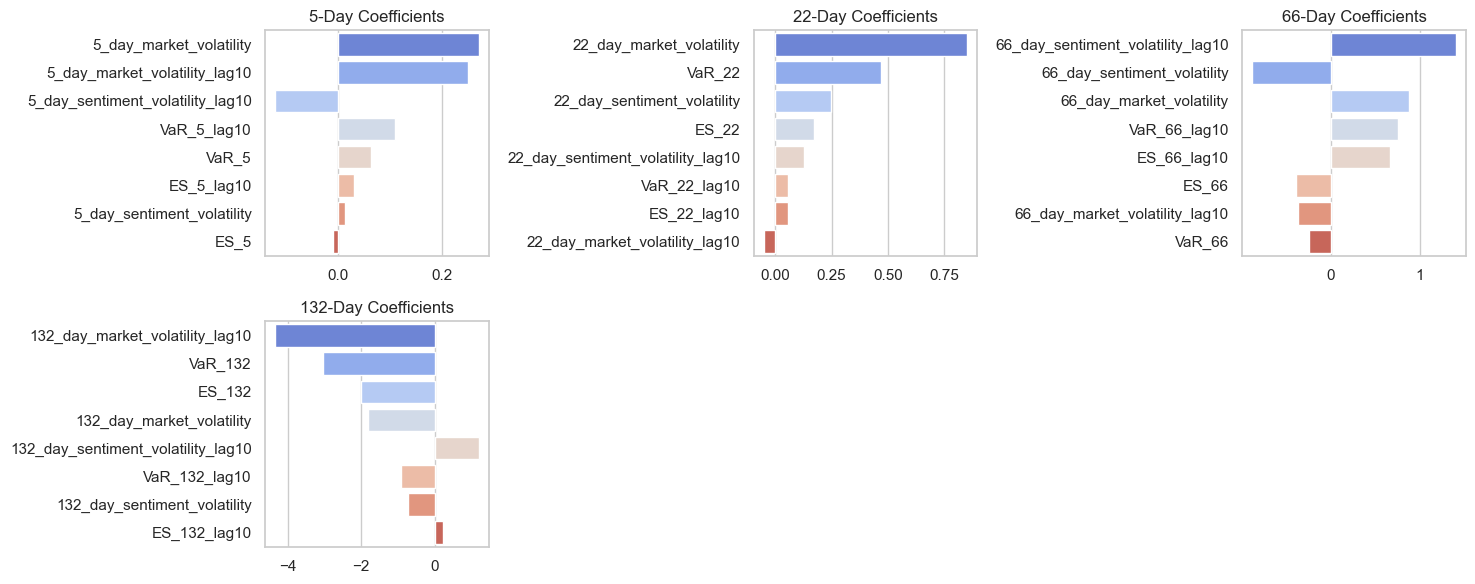

In [388]:
plot_logit_coefficients_grid(logit_results)

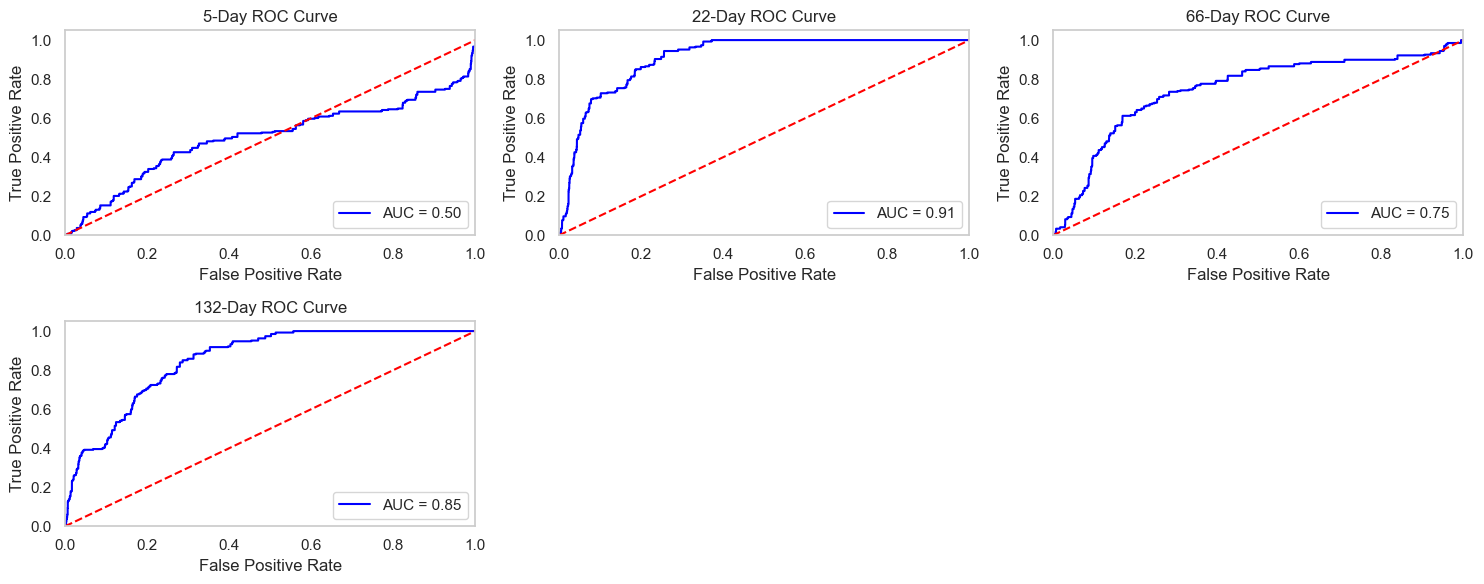

In [389]:
plot_roc_curves_grid(logit_results, X_test_dict, y_test_dict)

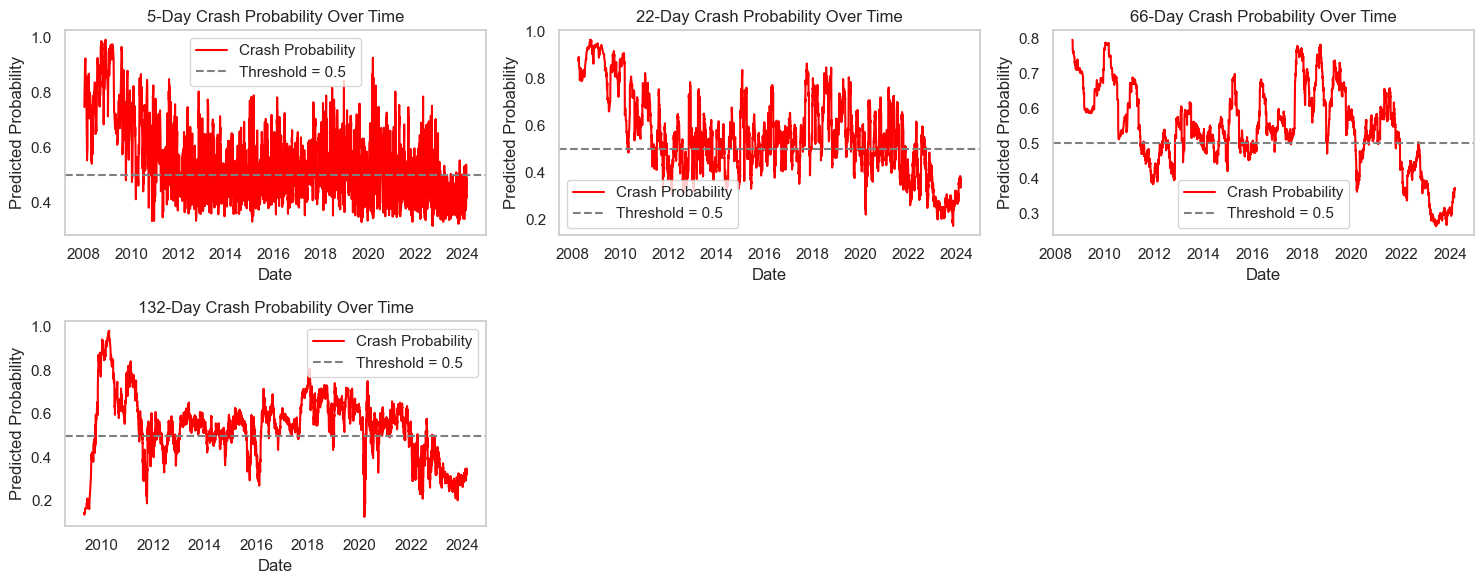

In [390]:
plot_crash_probabilities_grid(logit_results, market_sentiment_data, target_col='future_crash')

### Dynamic Logit Regression with Combined Features and Dynamic Threshold

In [393]:
# Define combined feature period
combined_period = 1

# Combine 5-day and 22-day features
combined_features = [
    f'22_day_sentiment_volatility',
    f'22_day_market_volatility',
]

market_sentiment_data_with_lags = market_sentiment_data.copy()

# Add lagged features
for feat in combined_features:
    market_sentiment_data_with_lags[f'{feat}_lag{lag}'] = market_sentiment_data[feat].shift(lag)

feature_cols = combined_features + [f'{f}_lag{lag}' for f in combined_features]

train_data = market_sentiment_data_with_lags[market_sentiment_data_with_lags['Date'] < '2022-01-01']
test_data = market_sentiment_data_with_lags[(market_sentiment_data_with_lags['Date'] >= '2022-01-01')]
train_df = train_data.dropna(subset=feature_cols+['future_crash']).copy()
test_df = test_data.dropna(subset=feature_cols+['future_crash']).copy()

# Prepare feature matrices and target vectors
X_train = train_df[feature_cols].fillna(train_df[feature_cols].mean())
y_train = train_df['future_crash']

X_test = test_df[feature_cols].fillna(train_df[feature_cols].mean())
y_test = test_df['future_crash']

X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)
X_test_scale = scaler.transform(X_test)

# Fit logistic regression
logit = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    max_iter=1000, 
    class_weight='balanced',
    C=1.0,
    l1_ratio=0.5)
logit.fit(X_resampled, y_resampled)

y_proba = logit.predict_proba(X_test_scale)[:, 1]
best_thresh = dynamic_threshold_calculate(y_test, y_proba)
y_pred = (y_proba >= best_thresh).astype(int)

# Evaluation
auc_score = roc_auc_score(y_test, y_proba)
report = classification_report(y_test, y_pred)

coefficients = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': logit.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Store results
logit_results[combined_period] = {
    'model': logit,
    'auc_score': auc_score,
    'report': report,
    'coefficients': coefficients,
}

X_test_dict[combined_period] = X_test
y_test_dict[combined_period] = y_test

# Print summary
print(f"\n=== Combined Logit Model ===")
print(f"AUC: {auc_score:.3f}")
print("Classification Report:")
print(report)

Best threshold: 0.44, F1: 0.41

=== Combined Logit Model ===
AUC: 0.928
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      7644
           1       0.33      0.55      0.41       268

    accuracy                           0.95      7912
   macro avg       0.66      0.76      0.69      7912
weighted avg       0.96      0.95      0.95      7912



Precision and Recall for Combined Model:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      7644
           1       0.33      0.55      0.41       268

    accuracy                           0.95      7912
   macro avg       0.66      0.76      0.69      7912
weighted avg       0.96      0.95      0.95      7912



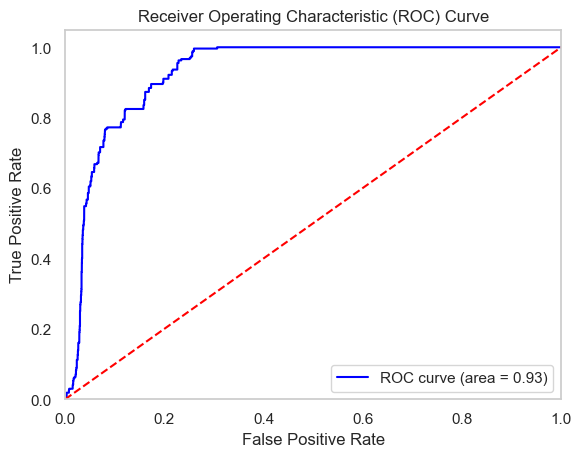

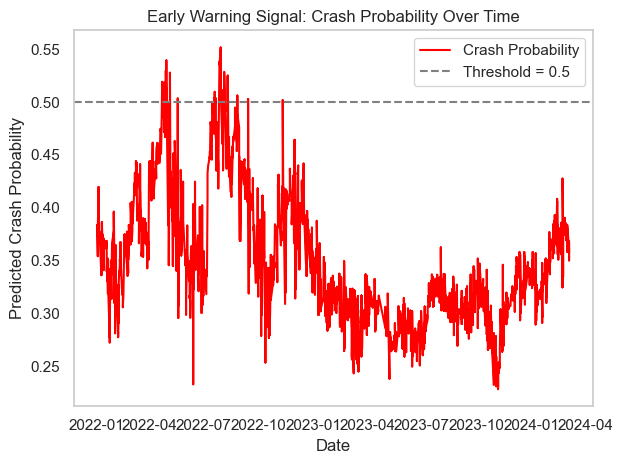

In [394]:
# Create DataFrame with dates and probabilities
dates = df_combined.loc[X_test.index, 'Date']
prob_df = pd.DataFrame({
    'Date': dates,
    'crash_probability': y_proba
}).sort_values('Date')

# Report precision and recall
print("Precision and Recall for Combined Model:")
print(classification_report(y_test, y_pred))

# Plot ROC curve
plot_roc_curve(y_test, y_proba)

# Plot crash probabilities
plot_crash_probabilities(prob_df, target_col='crash_probability')

### CNN

In [458]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from sklearn.utils import class_weight

cnn_results = {}
X_test_dict = {}
y_test_dict = {}
window_size = 22  # Default window size for CNN

for n in volatility_period:
    feature_cols = [
        f'{n}_day_market_volatility',
        f'{n}_day_sentiment_volatility',
        f'VaR_{n}',
        f'ES_{n}',
    ]

    train_data = market_sentiment_data_with_lags[market_sentiment_data_with_lags['Date'] < '2022-01-01']
    test_data = market_sentiment_data_with_lags[(market_sentiment_data_with_lags['Date'] >= '2022-01-01')]
    train_df = train_data.dropna(subset=feature_cols+['future_crash']).copy()
    test_df = test_data.dropna(subset=feature_cols+['future_crash']).copy()

    # Prepare feature matrices and target vectors
    X_train = train_df[feature_cols].fillna(train_df[feature_cols].mean())
    y_train = train_df['future_crash']
    X_train_raw = X_train.values
    y_train_raw = y_train.values

    X_test = test_df[feature_cols].fillna(train_df[feature_cols].mean())
    y_test = test_df['future_crash']
    X_test_raw = X_test.values
    y_test_raw = y_test.values

    # X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)
    X_train_resampled, y_train_resampled = X_train_raw, y_train_raw  # For simplicity, using original training data without resampling

    # Convert to DataFrame for convenience
    X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)
    y_train_resampled = pd.Series(y_train_resampled)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_resampled)
    X_test_scaled = scaler.transform(X_test_raw)

    X_train_seq, y_train_seq, _ = create_sequences(pd.DataFrame(X_train_scaled, columns=X_train.columns), y_train_resampled, window=window_size)
    X_test_seq, y_test_seq, _ = create_sequences(pd.DataFrame(X_test_scaled, columns=X_test.columns), pd.Series(y_test_raw), window=window_size)

    # Define CNN model
    cnn_model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, X_train_seq.shape[2])),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        GlobalMaxPooling1D(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary classification
    ])

    cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

    class_weights_array = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_seq),
        y=y_train_seq
    )
    class_weight_dict = dict(enumerate(class_weights_array))

    # Train
    cnn_model.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, validation_split=0.2, verbose=0, 
                class_weight=class_weight_dict)

    y_prob = cnn_model.predict(X_test_seq).flatten()
    best_threshold = dynamic_threshold_calculate(y_test_seq, y_prob)
    y_pred = (y_prob > best_threshold).astype(int)

    # Evaluate
    auc = roc_auc_score(y_test_seq, y_prob)
    report = classification_report(y_test_seq, y_pred)

    # Save model and results
    cnn_results[n] = {
        'model': cnn_model,
        'auc_score': auc_score,
        'report': report,
        'y_test': y_test_seq,
        'y_prob': y_prob,
        'features': feature_cols,
    }

    X_test_dict[n] = X_test_seq
    y_test_dict[n] = y_test_seq

    print(f"\n=== {n}-Day CNN Model ===")
    print(f"AUC: {auc:.3f}")
    print(report)

247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Best threshold: 0.00, F1: 0.07

=== 5-Day CNN Model ===
AUC: 0.203
              precision    recall  f1-score   support

           0       0.99      0.01      0.03      7622
           1       0.03      1.00      0.07       268

    accuracy                           0.05      7890
   macro avg       0.51      0.50      0.05      7890
weighted avg       0.96      0.05      0.03      7890

247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Best threshold: 0.28, F1: 0.29

=== 22-Day CNN Model ===
AUC: 0.890
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      7622
           1       0.18      0.67      0.29       268

    accuracy                           0.89      7890
   macro avg       0.59      0.78      0.61      7890
weighted avg       0.96      0.89      0.92      7890

247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Best threshold: 0.00, F1: 0.23

=== 66-Day CNN Model ===
AUC: 0.829
              precis

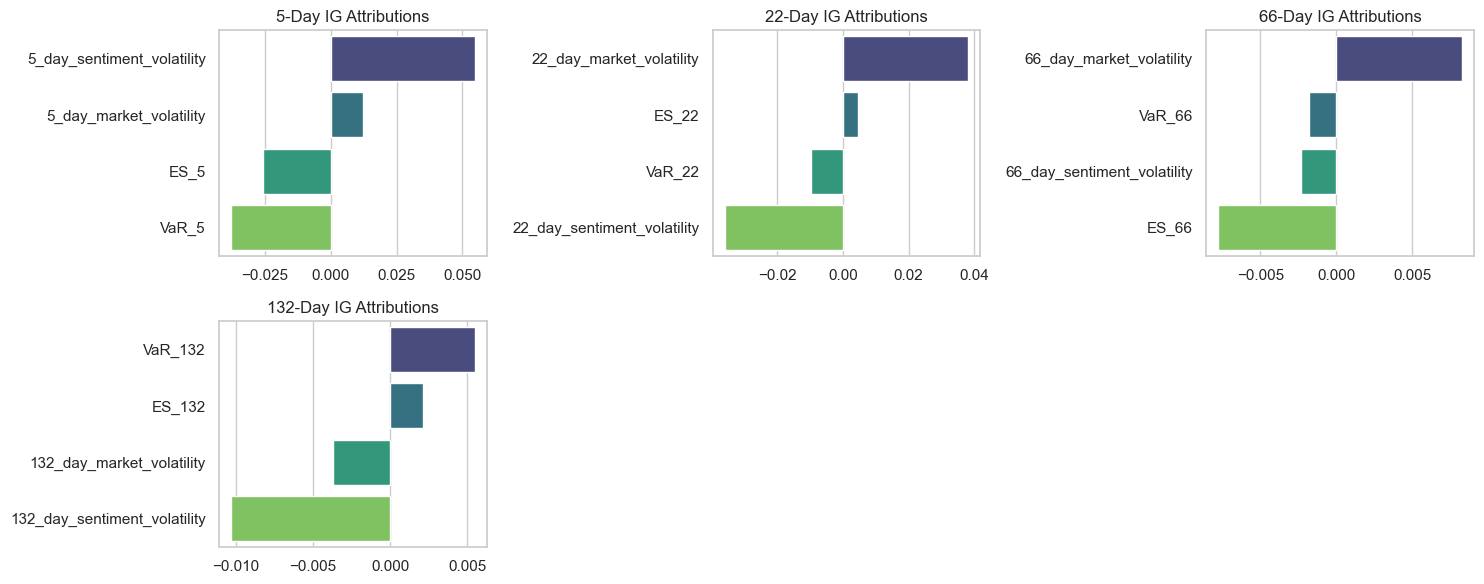

247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


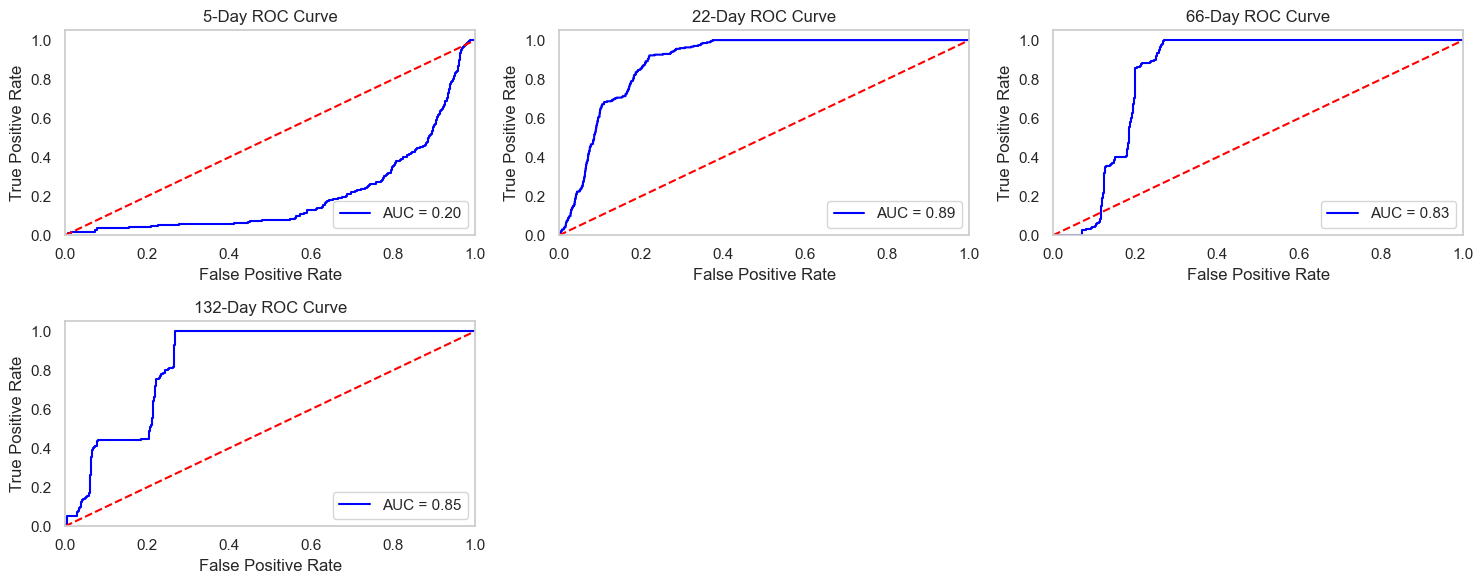

597/597 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
597/597 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
595/595 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
592/592 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


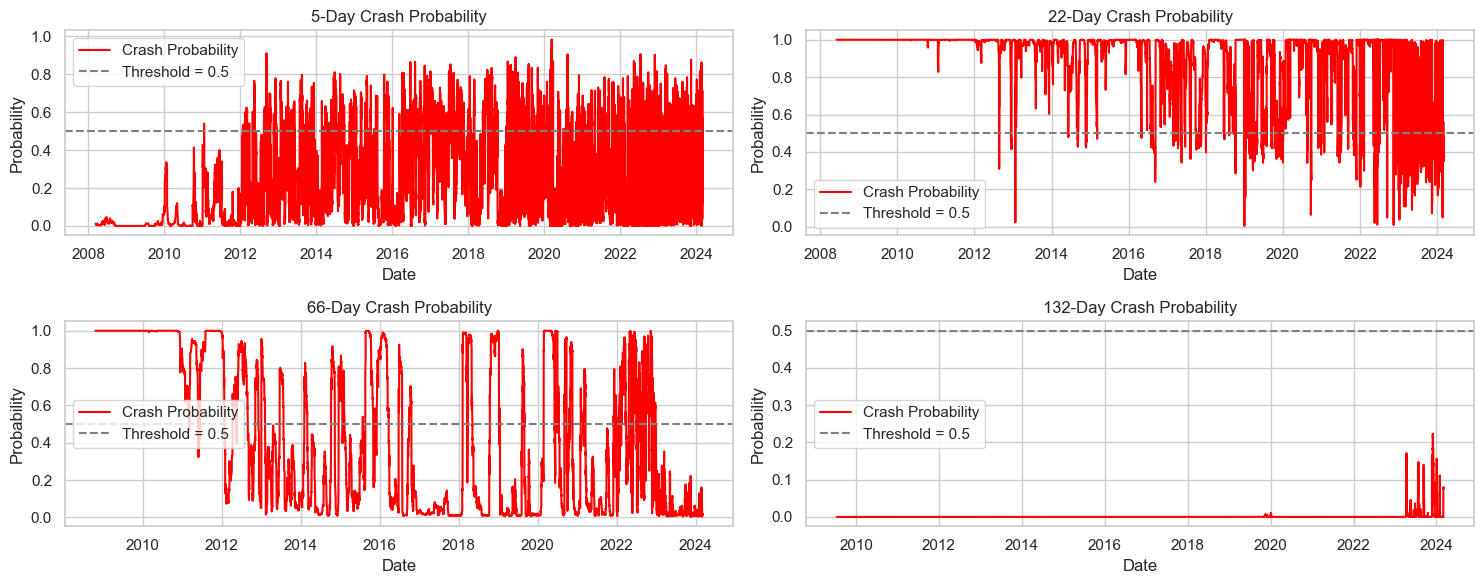

In [459]:
plot_ig_feature_attributions_grid(cnn_results, X_test_dict, window_size=window_size)
plot_CNN_roc_curves_grid(cnn_results, X_test_dict, y_test_dict)
plot_crash_probabilities_grid_CNN(cnn_results, market_sentiment_data, window_size=window_size)

### CNN with Combined Features and Dynamic Threshold

In [429]:
# Define combined feature period
n = 99
window_size = 30  # Default window size for CNN

feature_cols = [
    f'5_day_market_volatility',
    f'5_day_sentiment_volatility',
    f'VaR_5',
    f'ES_5',
    f'22_day_market_volatility',
    f'22_day_sentiment_volatility',
    f'VaR_22',
    f'ES_22',
    f'66_day_market_volatility',
    f'66_day_sentiment_volatility',
    f'VaR_66',
    f'ES_66',
    f'132_day_market_volatility',
    f'132_day_sentiment_volatility',
    f'VaR_132',
    f'ES_132',
]

train_data = market_sentiment_data_with_lags[market_sentiment_data_with_lags['Date'] < '2022-01-01']
test_data = market_sentiment_data_with_lags[(market_sentiment_data_with_lags['Date'] >= '2022-01-01')]
train_df = train_data.dropna(subset=feature_cols+['future_crash']).copy()
test_df = test_data.dropna(subset=feature_cols+['future_crash']).copy()

# Prepare feature matrices and target vectors
X_train = train_df[feature_cols].fillna(train_df[feature_cols].mean())
y_train = train_df['future_crash']
X_train_raw = X_train.values
y_train_raw = y_train.values

X_test = test_df[feature_cols].fillna(train_df[feature_cols].mean())
y_test = test_df['future_crash']
X_test_raw = X_test.values
y_test_raw = y_test.values

# X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)
X_train_resampled, y_train_resampled = X_train_raw, y_train_raw  # For simplicity, using original training data without resampling

# Convert to DataFrame for convenience
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)
y_train_resampled = pd.Series(y_train_resampled)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test_raw)

X_train_seq, y_train_seq, _ = create_sequences(pd.DataFrame(X_train_scaled, columns=X_train.columns), y_train_resampled, window=window_size)
X_test_seq, y_test_seq, _ = create_sequences(pd.DataFrame(X_test_scaled, columns=X_test.columns), pd.Series(y_test_raw), window=window_size)

# Define CNN model
cnn_model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(window_size, X_train_seq.shape[2])),
    MaxPooling1D(pool_size=2),
    GlobalMaxPooling1D(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_seq),
    y=y_train_seq
)
class_weight_dict = dict(enumerate(class_weights_array))

# Train
cnn_model.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, validation_split=0.2, verbose=0, 
                class_weight=class_weight_dict)

y_prob = cnn_model.predict(X_test_seq).flatten()
best_threshold = dynamic_threshold_calculate(y_test_seq, y_prob)
y_pred = (y_prob > best_threshold).astype(int)

# Evaluate
auc = roc_auc_score(y_test_seq, y_prob)
report = classification_report(y_test_seq, y_pred)

# Save model and results
cnn_results[n] = {
    'model': cnn_model,
    'auc_score': auc_score,
    'report': report,
    'y_test': y_test_seq,
    'y_prob': y_prob,
    'features': feature_cols,
}

X_test_dict[n] = X_test_seq
y_test_dict[n] = y_test_seq

print(f"\n=== {n}-Day CNN Model ===")
print(f"AUC: {auc:.3f}")
print(report)

247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Best threshold: 0.00, F1: 0.17

=== 99-Day CNN Model ===
AUC: 0.815
              precision    recall  f1-score   support

           0       1.00      0.67      0.80      7614
           1       0.10      0.99      0.17       268

    accuracy                           0.68      7882
   macro avg       0.55      0.83      0.49      7882
weighted avg       0.97      0.68      0.78      7882



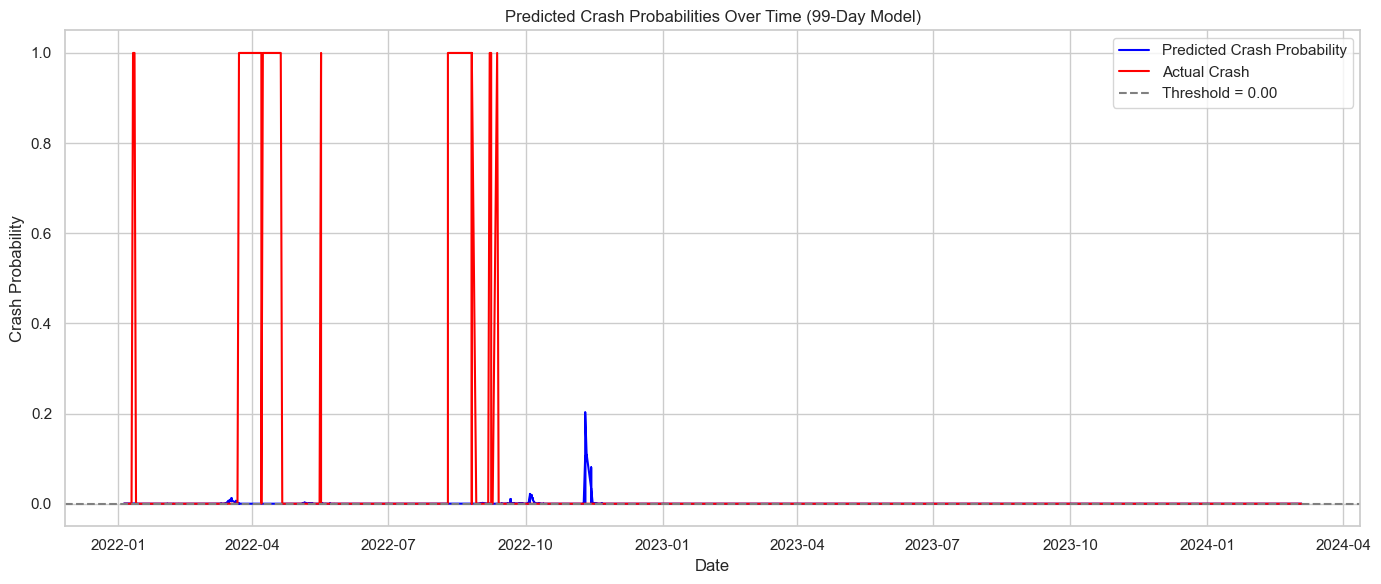

In [ ]:
# Recover dates aligned with the test sequence (drop first `window_size - 1` rows)
date_seq = test_df['Date'].iloc[window_size:].reset_index(drop=True)

# Create a DataFrame to plot
prob_df = pd.DataFrame({
    'Date': date_seq,
    'Crash_Probability': y_prob,
    'Actual_Crash': y_test_seq,
})

# Sort by date just in case
prob_df = prob_df.sort_values('Date')

# Plot
plt.figure(figsize=(14, 6))
plt.plot(prob_df['Date'], prob_df['Crash_Probability'], label='Predicted Crash Probability', color='blue')
plt.plot(prob_df['Date'], prob_df['Actual_Crash'], color='red', label='Actual Crash')
plt.axhline(y=best_threshold, color='gray', linestyle='--', label=f'Threshold = {best_threshold:.2f}')
plt.title(f'Predicted Crash Probabilities Over Time ({n}-Day Model)')
plt.xlabel('Date')
plt.ylabel('Crash Probability')
plt.legend()
plt.tight_layout()
plt.show()

### LSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

lstm_results = {}
X_test_dict = {}
y_test_dict = {}

window_size = 30  # Default window size 

for n in volatility_period:
    feature_cols = [
        f'{n}_day_market_volatility',
        f'{n}_day_sentiment_volatility',
        f'VaR_{n}',
        f'ES_{n}',
    ]

    train_data = market_sentiment_data_with_lags[market_sentiment_data_with_lags['Date'] < '2022-01-01']
    test_data = market_sentiment_data_with_lags[(market_sentiment_data_with_lags['Date'] >= '2022-01-01')]
    train_df = train_data.dropna(subset=feature_cols+['future_crash']).copy()
    test_df = test_data.dropna(subset=feature_cols+['future_crash']).copy()

    # Prepare feature matrices and target vectors
    X_train = train_df[feature_cols].fillna(train_df[feature_cols].mean())
    y_train = train_df['future_crash']
    X_train_raw = X_train.values
    y_train_raw = y_train.values

    X_test = test_df[feature_cols].fillna(train_df[feature_cols].mean())
    y_test = test_df['future_crash']
    X_test_raw = X_test.values
    y_test_raw = y_test.values

    # X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)
    X_train_resampled, y_train_resampled = X_train_raw, y_train_raw  # For simplicity, using original training data without resampling

    # Convert to DataFrame for convenience
    X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)
    y_train_resampled = pd.Series(y_train_resampled)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_resampled)
    X_test_scaled = scaler.transform(X_test_raw)

    X_train, y_train, _ = create_sequences(pd.DataFrame(X_train_scaled, columns=X_train.columns), y_train_resampled, window=window_size)
    X_test, y_test, _ = create_sequences(pd.DataFrame(X_test_scaled, columns=X_test.columns), pd.Series(y_test_raw), window=window_size)


    lstm_model = Sequential([
        LSTM(64, return_sequences=False, input_shape=(window_size, X_train.shape[2])),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['AUC'])

    lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

    # Predict
    y_prob = lstm_model.predict(X_test).flatten()
    best_threshold = dynamic_threshold_calculate(y_test, y_prob)
    y_pred = (y_prob > best_threshold).astype(int)

    # Evaluate
    auc = roc_auc_score(y_test, y_prob)
    report = classification_report(y_test, y_pred)

    # Save model and results
    lstm_results[n] = {
        'model': lstm_model,
        'auc_score': auc_score,
        'report': report,
        'y_test': y_test,
        'y_prob': y_prob,
        'features': feature_cols,
    }

    X_test_dict[n] = X_test
    y_test_dict[n] = y_test

    print(f"\n=== {n}-Day LSTM Model ===")
    print(f"AUC: {auc:.3f}")
    print(report)

Epoch 1/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - AUC: 0.5327 - loss: 0.3161 - val_AUC: 0.0000e+00 - val_loss: 0.0870
Epoch 2/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - AUC: 0.6892 - loss: 0.2046 - val_AUC: 0.0000e+00 - val_loss: 0.0607
Epoch 3/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - AUC: 0.7314 - loss: 0.1875 - val_AUC: 0.0000e+00 - val_loss: 0.0593
Epoch 4/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - AUC: 0.7265 - loss: 0.1940 - val_AUC: 0.0000e+00 - val_loss: 0.0950
Epoch 5/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - AUC: 0.7308 - loss: 0.1852 - val_AUC: 0.0000e+00 - val_loss: 0.1353
Epoch 6/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - AUC: 0.7649 - loss: 0.1817 - val_AUC: 0.0000e+00 - val_loss: 0.0805
Epoch 7/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - AUC: 0.7955 - loss: 0.1587 - val_AUC: 0.0000e+00 - val_loss: 0.0935
Epoch 8/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - AUC: 0.8084 - loss: 0.1715 - val_AUC: 0.0000e+00 - val_loss: 0.0949
Epoch 9/10
280/280 ━━━━━

In [447]:
for n in volatility_period:
    print(f"\n=== {n}-Day LSTM Model ===")
    print(f"AUC: {lstm_results[n]['auc_score']:.3f}")
    print(lstm_results[n]['report'])


=== 5-Day LSTM Model ===
AUC: 0.928
              precision    recall  f1-score   support

           0       0.97      0.01      0.01      7614
           1       0.03      1.00      0.07       268

    accuracy                           0.04      7882
   macro avg       0.50      0.50      0.04      7882
weighted avg       0.94      0.04      0.01      7882


=== 22-Day LSTM Model ===
AUC: 0.928
              precision    recall  f1-score   support

           0       0.99      0.94      0.96      7614
           1       0.25      0.62      0.36       268

    accuracy                           0.92      7882
   macro avg       0.62      0.78      0.66      7882
weighted avg       0.96      0.92      0.94      7882


=== 66-Day LSTM Model ===
AUC: 0.928
              precision    recall  f1-score   support

           0       0.99      0.83      0.90      7614
           1       0.14      0.80      0.24       268

    accuracy                           0.83      7882
   macro avg   

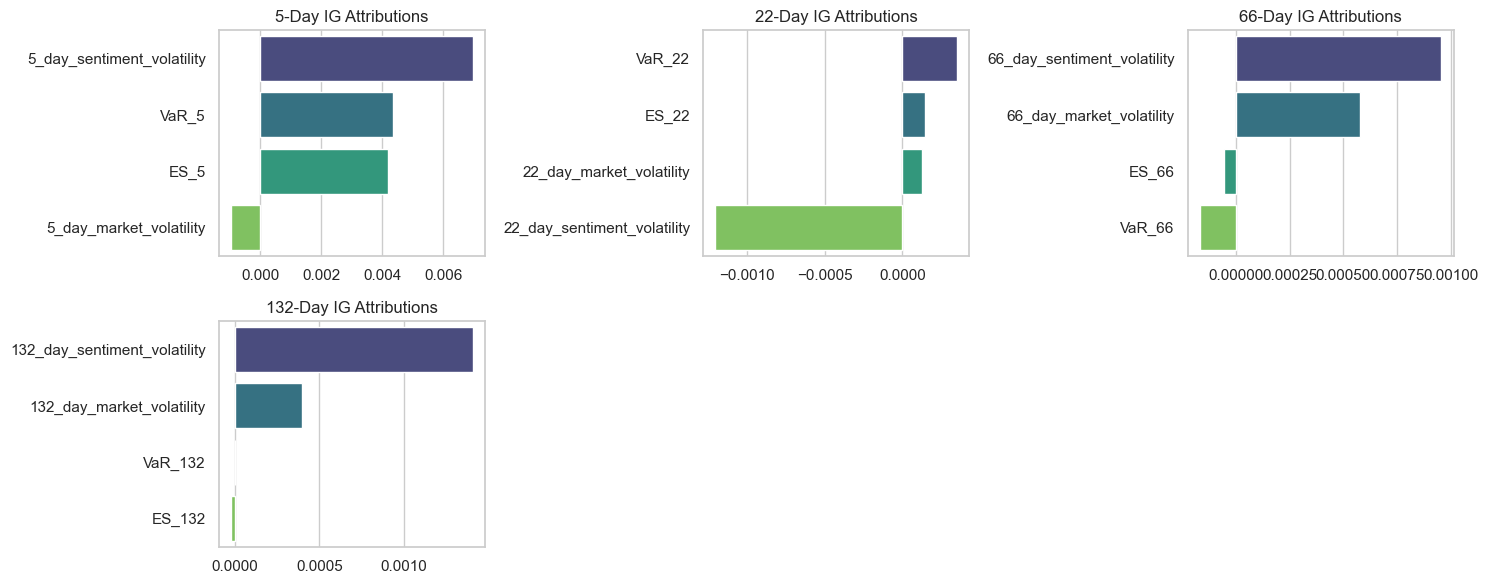

247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


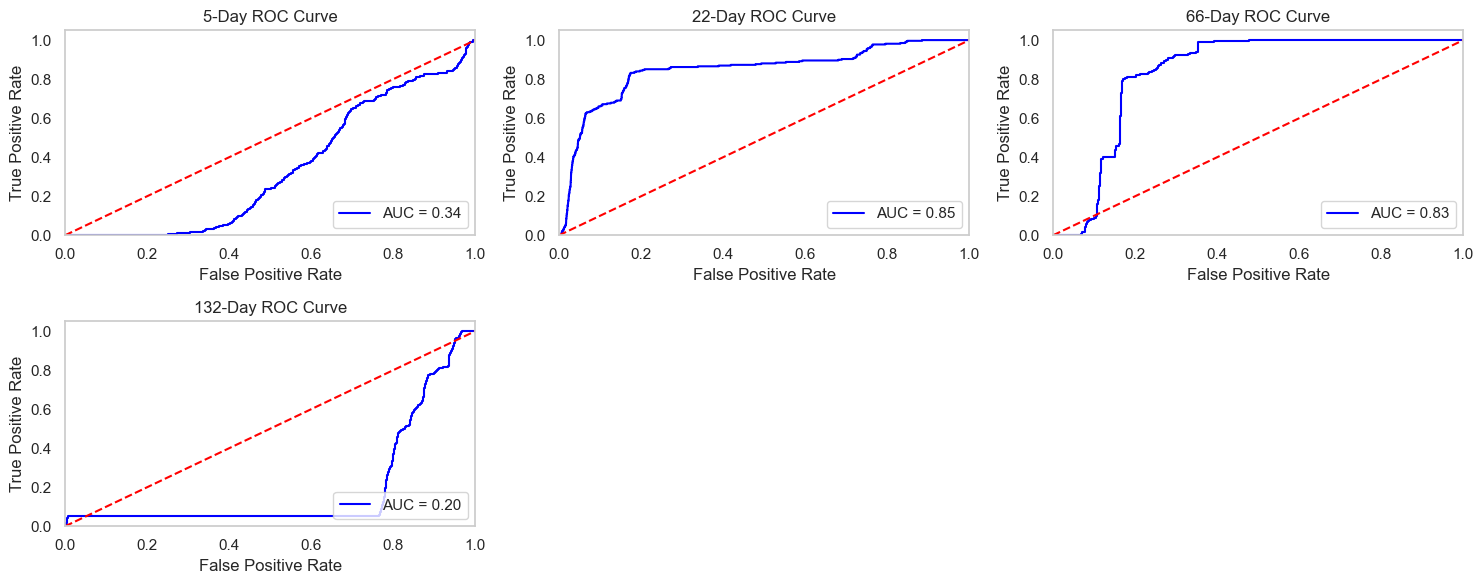

597/597 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
596/596 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
595/595 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
592/592 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


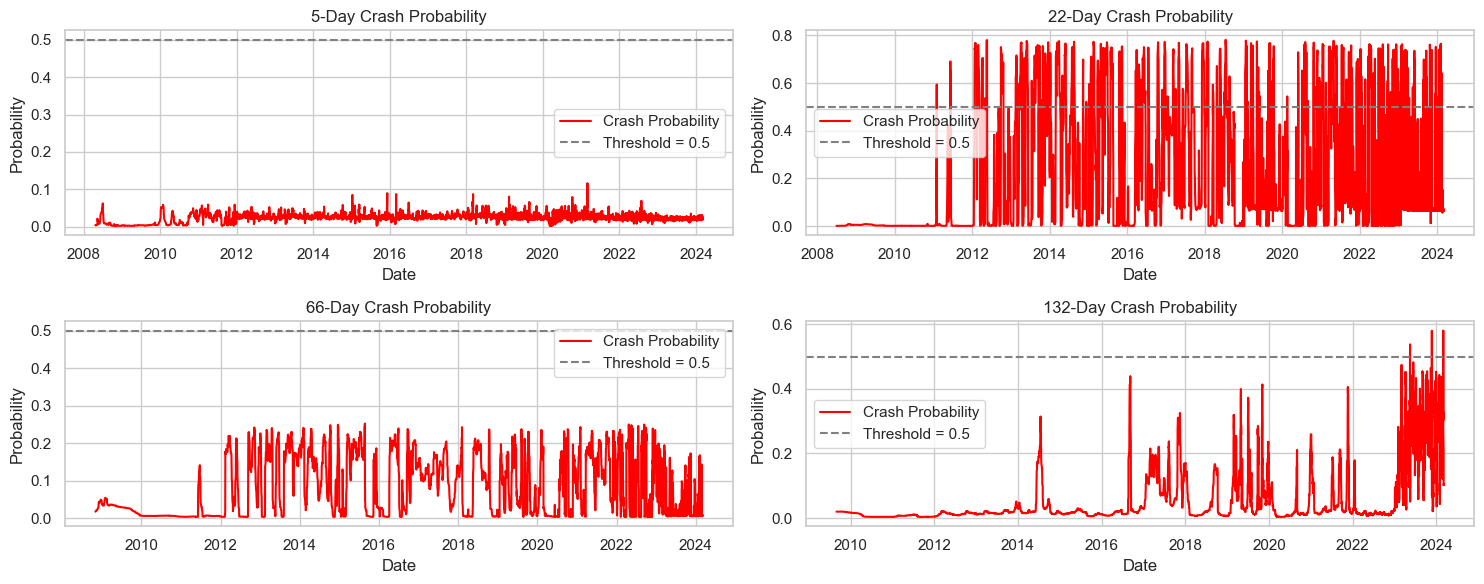

In [448]:
plot_ig_feature_attributions_grid(lstm_results, X_test_dict, window_size=window_size)
plot_CNN_roc_curves_grid(lstm_results, X_test_dict, y_test_dict)
plot_crash_probabilities_grid_CNN(lstm_results, market_sentiment_data, window_size=window_size)

In [450]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

lstm_results = {}
X_test_dict = {}
y_test_dict = {}
# Match window size to volatility periods
# window_sizes = [5, 22, 66, 126, 252]
window_size = 30  # Default window size 

for n in volatility_period:
    feature_cols = [
        f'{n}_day_market_volatility',
        f'{n}_day_sentiment_volatility',
        f'VaR_{n}',
        f'ES_{n}',
    ]

    # Drop NA values
    df_model = market_sentiment_data.dropna(subset=feature_cols + ['future_crash']).copy()
    X_raw = df_model[feature_cols].fillna(0)
    y_raw = df_model['future_crash']

    # Flatten features (tabular form)
    X_flat = X_raw.values
    y_flat = y_raw.values

    # Apply SMOTE
    sm = SMOTE(random_state=RANDOM_STATE)
    X_resampled, y_resampled = sm.fit_resample(X_flat, y_flat)

    # Convert back to DataFrame for convenience
    X_resampled = pd.DataFrame(X_resampled, columns=X_raw.columns)
    y_resampled = pd.Series(y_resampled, name='future_crash')

    # Create time-series sequences
    X_seq, y_seq, _ = create_sequences(X_resampled, y_resampled, window=window_size)

    # Split train/test
    X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, stratify=y_seq, test_size=0.2, random_state=RANDOM_STATE)


    lstm_model = Sequential([
        LSTM(64, return_sequences=False, input_shape=(window_size, X_train.shape[2])),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['AUC'])

    lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

    # Predict
    y_prob = lstm_model.predict(X_test).flatten()

    best_threshold = dynamic_threshold_calculate(y_test, y_prob)
    y_pred = (y_prob > best_threshold).astype(int)

    # Evaluate
    auc = roc_auc_score(y_test, y_prob)
    report = classification_report(y_test, y_pred, output_dict=True)

    # Save model and results
    lstm_results[n] = {
        'model': lstm_model,
        'auc_score': auc_score,
        'report': report,
        'y_test': y_test,
        'y_prob': y_prob,
        'features': feature_cols,
    }

    X_test_dict[n] = X_test
    y_test_dict[n] = y_test

    print(f"\n=== {n}-Day LSTM Model ===")
    print(f"AUC: {auc:.3f}")

Epoch 1/10
733/733 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - AUC: 0.9171 - loss: 0.3259 - val_AUC: 0.9818 - val_loss: 0.1056
Epoch 2/10
733/733 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - AUC: 0.9842 - loss: 0.0993 - val_AUC: 0.9827 - val_loss: 0.0970
Epoch 3/10
733/733 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - AUC: 0.9864 - loss: 0.0882 - val_AUC: 0.9822 - val_loss: 0.1008
Epoch 4/10
733/733 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - AUC: 0.9866 - loss: 0.0870 - val_AUC: 0.9839 - val_loss: 0.0942
Epoch 5/10
733/733 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - AUC: 0.9870 - loss: 0.0837 - val_AUC: 0.9843 - val_loss: 0.0997
Epoch 6/10
733/733 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - AUC: 0.9870 - loss: 0.0876 - val_AUC: 0.9855 - val_loss: 0.0912
Epoch 7/10
733/733 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - AUC: 0.9872 - loss: 0.0873 - val_AUC: 0.9855 - val_loss: 0.0935
Epoch 8/10
733/733 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - AUC: 0.9874 - loss: 0.0844 - val_AUC: 0.9860 - val_loss: 0.0926
Epoch 9/10
733/733 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - AU

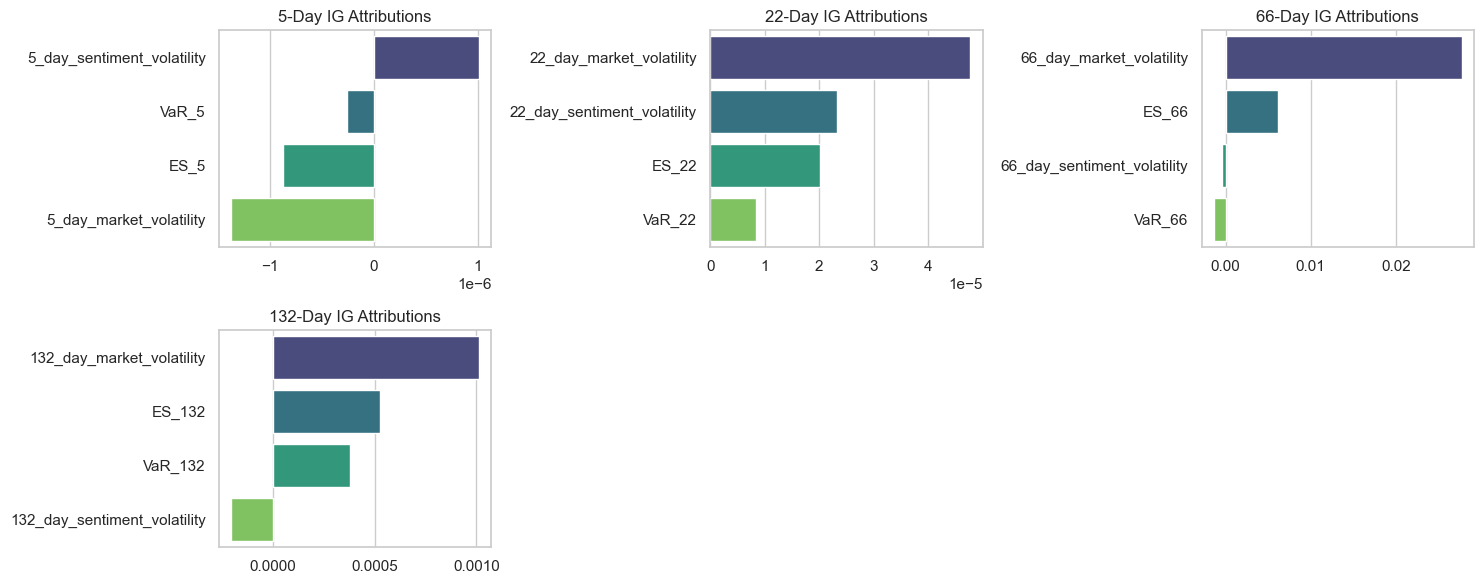

229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


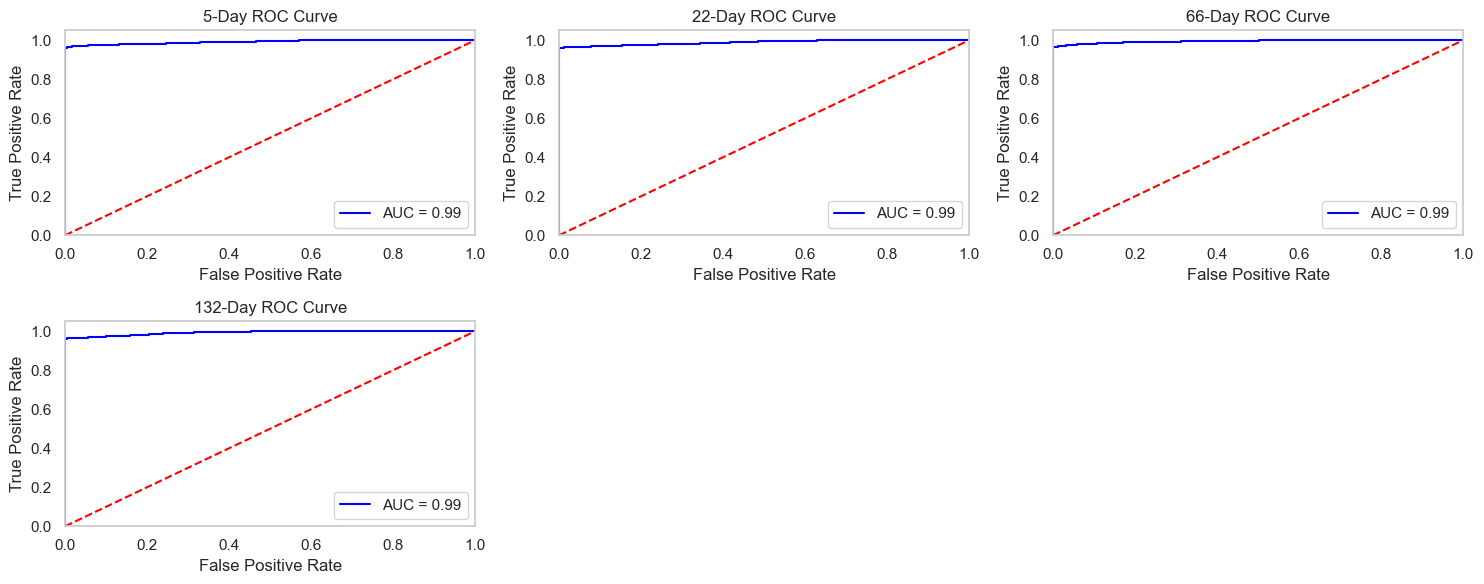

597/597 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
596/596 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
595/595 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
592/592 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


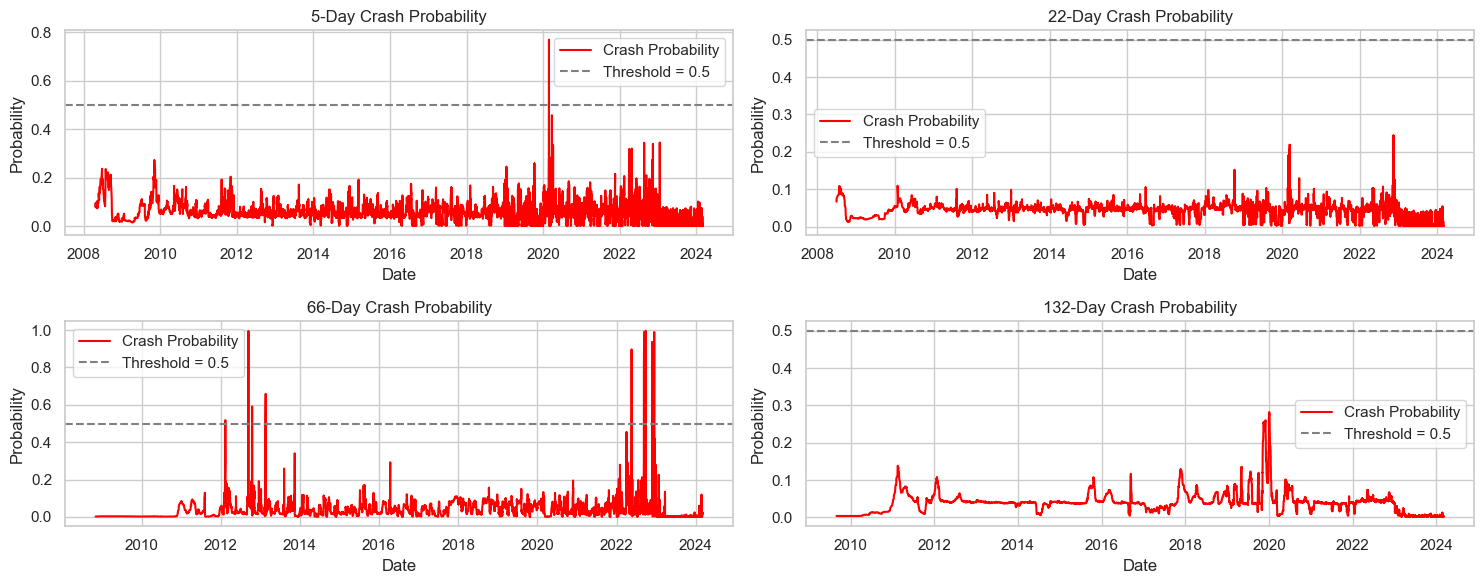

In [451]:
plot_ig_feature_attributions_grid(lstm_results, X_test_dict, window_size=window_size)
plot_CNN_roc_curves_grid(lstm_results, X_test_dict, y_test_dict)
plot_crash_probabilities_grid_CNN(lstm_results, market_sentiment_data, window_size=window_size)

### LSTM with Combined Features and Dynamic Threshold

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

lstm_model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(window_size, X_train.shape[2])),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['AUC'])

lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - AUC: 0.5112 - loss: 0.1984 - val_AUC: 0.6251 - val_loss: 0.1589
Epoch 2/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6635 - loss: 0.1491 - val_AUC: 0.7626 - val_loss: 0.1563
Epoch 3/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7222 - loss: 0.1523 - val_AUC: 0.7647 - val_loss: 0.1456
Epoch 4/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7452 - loss: 0.1484 - val_AUC: 0.7898 - val_loss: 0.1442
Epoch 5/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7744 - loss: 0.1430 - val_AUC: 0.8035 - val_loss: 0.1343
Epoch 6/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7922 - loss: 0.1346 - val_AUC: 0.8484 - val_loss: 0.1320
Epoch 7/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7831 - loss: 0.1480 - val_AUC: 0.8391 - val_loss: 0.1387
Epoch 8/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.8008 - loss: 0.1359 - val_AUC: 0.8467 - val_loss: 0.1320
Epoch 9/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AU

In [ ]:
y_prob = lstm_model.predict(X_test).flatten()
y_pred = (y_prob > 0.5).astype(int)

print(classification_report(y_test, y_pred))

120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3664
           1       1.00      0.08      0.14       157

    accuracy                           0.96      3821
   macro avg       0.98      0.54      0.56      3821
weighted avg       0.96      0.96      0.95      3821



598/598 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


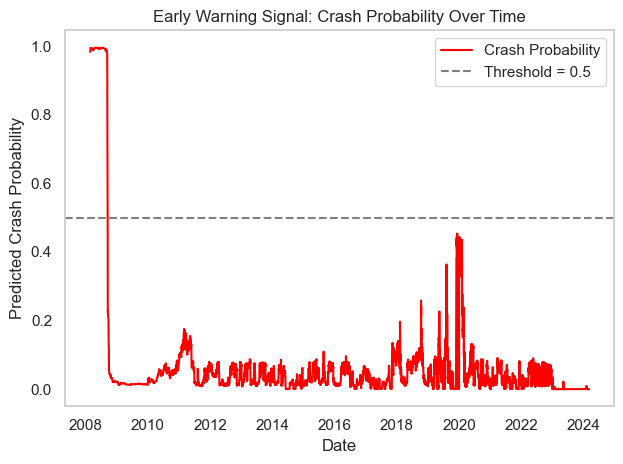

In [ ]:
crash_prob = lstm_model.predict(X_seq).flatten()
df_model = market_sentiment_data.copy()
df_plot = df_model.iloc[window_size:].copy()
df_plot['crash_probability'] = crash_prob

plot_crash_probabilities(df_plot, target_col='crash_probability')

## RF + Logit

In [297]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# --- Setup ---
RANDOM_STATE = 42

# Select features and target
features = [
    '5_day_market_volatility',
    '5_day_sentiment_volatility',
    'VaR_5',
    'ES_5',
    '22_day_market_volatility',
    '22_day_sentiment_volatility',
    'VaR_22',
    'ES_22',
    '66_day_market_volatility',
    '66_day_sentiment_volatility',
    'VaR_66',
    'ES_66',
    '132_day_market_volatility',
    '132_day_sentiment_volatility',
    'VaR_132',
    'ES_132',
]
target = 'future_crash'

# Drop NA values
df_model = market_sentiment_data.dropna(subset=features + [target]).copy()
X = df_model[features]
y = df_model[target]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=RANDOM_STATE)

# --- Step 1: Random Forest for Feature Selection ---
rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, class_weight='balanced', max_depth=10, min_samples_split=5, min_samples_leaf=2)
rf.fit(X_train, y_train)

# Get feature importances
feat_importances = pd.Series(rf.feature_importances_, index=features)
top_features = feat_importances.sort_values(ascending=False).head(5).index.tolist()

print("Top Features from Random Forest:")
print(top_features)

# --- Step 2: Logistic Regression with Top Features ---
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_top)
X_test_scaled = scaler.transform(X_test_top)

# Fit logistic regression
logit = LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced')
logit.fit(X_train_scaled, y_train)

# Predict
y_proba = logit.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

# Evaluation
auc = roc_auc_score(y_test, y_proba)
report = classification_report(y_test, y_pred)

# Coefficients
coefs = pd.DataFrame({
    'Feature': top_features,
    'Coefficient': logit.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

print("\n=== Logistic Regression Results ===")
print(f"AUC: {auc:.3f}")
print(report)


Top Features from Random Forest:
['132_day_sentiment_volatility', '22_day_sentiment_volatility', '66_day_sentiment_volatility', 'VaR_132', 'ES_132']

=== Logistic Regression Results ===
AUC: 0.680
              precision    recall  f1-score   support

           0       0.98      0.57      0.72      3649
           1       0.06      0.65      0.10       143

    accuracy                           0.58      3792
   macro avg       0.52      0.61      0.41      3792
weighted avg       0.94      0.58      0.70      3792



In [298]:
from sklearn.metrics import recall_score, confusion_matrix, accuracy_score, mean_squared_error
import statsmodels.api as sm
import numpy as np

# Assume y_test, y_pred, y_proba, and X_train_scaled already defined
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

sensitivity = recall_score(y_test, y_pred, pos_label=1)
specificity = tn / (tn + fp)
misclass_error = 1 - accuracy_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_proba))

# McFadden's R² and AIC via statsmodels
X_train_const = sm.add_constant(X_train_scaled)
logit_model = sm.Logit(y_train, X_train_const).fit(disp=False)

mcfadden_r2 = 1 - logit_model.llf / logit_model.llnull
aic = logit_model.aic

print("Sensitivity (Recall for 1):", round(sensitivity, 3))
print("Specificity (True Negative Rate):", round(specificity, 3))
print("Misclassification Error:", round(misclass_error, 3))
print("RMSE:", round(rmse, 3))
print("McFadden Pseudo R²:", round(mcfadden_r2, 3))
print("AIC:", round(aic, 2))

Sensitivity (Recall for 1): 0.65
Specificity (True Negative Rate): 0.574
Misclassification Error: 0.424
RMSE: 0.483
McFadden Pseudo R²: 0.039
AIC: 4699.74
